# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# Set some switches

In [2]:
do_sa = False # For seasonal adjustment
select_vars_manually = False # Set to true if you want to choose variables manually
use_custom_weights = False # If we want to use customised weights
generate_plots = True # Choose whther to generate plots

# Put your chosen variables here
manual_vars = ['Export Value', 'Import Value']


# Load Data

In [3]:
# filename = 'Composite Index March 2025.xlsx'
# sheets = pd.ExcelFile(filename).sheet_names

# # sheets
# df = pd.read_excel(filename, sheet_name="Data ")
# df.columns = df.columns.str.strip()

# metadata = df.loc[[i for i in range(4)], :]
# df.drop(index=[i for i in range(4)], inplace=True)


# # change to numeric
# for col in df.columns[1:]:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# df['Description'] = pd.to_datetime(df['Description'], format="%Y-%m-%d %H-%M-%S").dt.normalize()
# df = df.set_index(df['Description'], drop=True)
# df.drop(columns=['Description'], inplace=True)
# # df['Description']

# df.head()

In [4]:
filename = 'DATABASE.xlsx'
dm = pd.read_excel(filename, sheet_name='DATA_M')
metadata = dm.loc[:27]
metadata.rename(columns={'Name_code (automtically generated)':'description'}, inplace=True)

tz_cols = ['Name_code (automtically generated)'] + [c for c in dm.columns if re.search(r'(?i)tz', str(c))] 
dm = dm[tz_cols]
dm.rename(columns={'Name_code (automtically generated)':'date'}, inplace=True)

# dm.columns


C:\Users\domin\AppData\Local\Temp\ipykernel_33612\2857701569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.rename(columns={'Name_code (automtically generated)':'description'}, inplace=True)


In [5]:
ciea_vars = ['M_TZ_M3_SU', 'M_TZ_CPS_SU', 'M_TZ_budgvat_SU', 'M_TZ_ph_SU','M_TZ_tourismrec_SU',
             'M_TZ_ELCTR_SU', 'M_TZ_gold_SU', 'M_TZ_budgexp_SU', 'M_TZ_budgrecur_SU', 'M_TZ_budgdev_SU',
             'M_TZ_exiseduty _SU', 'M_TZ_deposits_SU', 'M_TZ_voil_SU', 'M_TZ_Paye_SU', 'M_TZ_REER_SU', 
             'M_TZ_bop_exp_SU','M_TZ_importvol_SU','M_TZ_bop_import_SU','M_TZ_mobpay_vol_SU', 
             'M_TZ_mobpay_val_SU', 'M_TZ_mobvoice_SU','M_TZ_tourist_arrival_SU', 'M_TZ_CMT_SU']

use_ciea_vars = False
if use_ciea_vars:
    df0 = dm.loc[28:,['date'] + ciea_vars]
else:
    df0 = dm.loc[28:]


df0['date'] = df0['date'].str.strip().str.upper()
str2num = [c for c in df0.columns if not re.search('date', str(c)) ]

for col in str2num:
    df0[col] = pd.to_numeric(df0[col], errors='coerce')

df0.columns =  df0.columns.str.replace("M_TZ_","")


# [c for c in dm.columns if re.search(r'(?i)imp', str(c))]
df0.set_index(pd.to_datetime(df0['date'],format="%YM%m"), inplace=True)
df0.drop(columns=['date'], inplace=True)

C:\Users\domin\AppData\Local\Temp\ipykernel_33612\671515969.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['date'] = df0['date'].str.strip().str.upper()
C:\Users\domin\AppData\Local\Temp\ipykernel_33612\671515969.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0[col] = pd.to_numeric(df0[col], errors='coerce')
C:\Users\domin\AppData\Local\Temp\ipykernel_33612\671515969.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [6]:
try:
    if use_ciea_vars:
        metadata = metadata[['description']+ciea_vars]
    metadata.columns = metadata.columns.str.replace("M_TZ_", "")
    var_description_dict = metadata.loc[metadata['description']=='Description'].to_dict(orient='records')[0]
except Exception as e:
    print(e)

In [7]:
m2q_method = metadata.loc[metadata['description'].str.contains('Method used for frequency convertion')].to_dict(orient='records')[0]
nom2real = metadata.loc[metadata['description'].str.contains('Nominal series that should be deflated')].to_dict(orient='records')[0]


In [8]:
from scipy import interpolate

gdp0 = pd.read_excel(filename, sheet_name='DATA_Q')
tz_cols = ['Name_code (automtically generated)'] + [c for c in gdp0.columns if re.search(r'(?i)tz', str(c))] 
gdp0 = gdp0[tz_cols]
gdp0.rename(columns={'Name_code (automtically generated)':'date'}, inplace=True)
gdp0
# [c for c in gdp0.columns if re.search(r'(?i)cmt', str(c))]
cols = ['date','Q_TZ_GDP15_SU', 'Q_TZ_CMT_SU']
gdp0 = gdp0.loc[28:,cols]

for c in cols[1:]:
    gdp0[c] = pd.to_numeric(gdp0[c], errors='coerce')

gdp0.rename(columns={'date':'yq'}, inplace=True)

gdp0['yq'] = pd.PeriodIndex(gdp0['yq'], freq='Q').to_timestamp(how='e').strftime("%Y-%m-%d")
gdp0['yq'] = pd.to_datetime(gdp0['yq'])
gdp0 = gdp0.loc[gdp0['yq'].dt.year>2001]

gdp0.set_index(gdp0['yq'], drop=True, inplace=True)
# gdp0.drop(columns=['yq'], inplace=True)

monthly_indices = pd.period_range(gdp0.index[0], gdp0.index.max(), freq='M').to_timestamp(how='e').strftime("%Y-%m-%d")
monthly_indices = pd.to_datetime(monthly_indices)
# # monthly_indices = pd.to_numeric(monthly_indices)


# # Interpolating cement data
cmt_m = gdp0['Q_TZ_CMT_SU'].dropna().resample('M').interpolate(method='cubicspline')/3

# Alternative
# # cubic_interpolation = interpolate.interp1d(quarters, gdp0['Q_TZ_CMT_SU'], kind='cubic', fill_value='extrapolate')
# # cmt_m = cubic_interpolation(months)
# # np.mean(cmt_m[-4:-2])
# # pd.ExcelFile(filename).sheet_names
gdp = gdp0.drop(columns=['Q_TZ_CMT_SU'])
gdp['yq'] = pd.PeriodIndex(gdp['yq'], freq='Q')
gdp.set_index(gdp['yq'], inplace=True)
gdp.rename(columns={'Q_TZ_GDP15_SU':'GDP'}, inplace=True)
gdp

yq           GDP
yq                          
2002Q1  2002Q1  1.052550e+07
2002Q2  2002Q2  1.049958e+07
2002Q3  2002Q3  9.601501e+06
2002Q4  2002Q4  1.075570e+07
2003Q1  2003Q1  1.113555e+07
...        ...           ...
2024Q1  2024Q1  3.873069e+07
2024Q2  2024Q2  3.836620e+07
2024Q3  2024Q3  3.752225e+07
2024Q4  2024Q4  4.194216e+07
2025Q1  2025Q1           NaN

[93 rows x 2 columns]

### Manual weights
- You need to make sure you have an `excel file` with manually chosen weights
- Otherwise, to make life easier you can make use of python dictionary to assign your weights

In [9]:
print(manual_vars)

['Export Value', 'Import Value']


In [10]:
# Use this if you have weights file, [tedious]
if use_custom_weights:
    # ===========================================================   #
    try: # w1                                                       #
        df_weights = pd.read_excel('weights.xlsx')                  #
        df_weights.columns = df_weights.columns.str.strip()         #
        custom_weights = df_weights.to_dict(orient='records')[0]    #
        df_weights.columns = df_weights.columns.str.strip()         #
        custom_weights = df_weights.to_dict(orient='records')[0]    #
    except Exception as e:                                          #
        print(f"Error: {e}")                                        #
        print("Please add your weights.xlsx file") # Wn # comment from W1-Wn if you want to set weights by dictionary 
    # ============================================================  #
    # Using weight dictionary, uncomment to use dictionary instead of weights file Example
    # user_weights = {}
    # user_weights['Export Value'] = 1
    # user_weights['Import Value'] = 1

    # custom_weights = user_weights

### GDP data

In [11]:
# gdp = pd.read_excel(filename, sheet_name="GDP")

# Generate GDP index

# Format GDP data
# gdp.set_index(pd.PeriodIndex(gdp['yq'].str.strip(), freq='Q'), inplace=True)
base_value = gdp.loc[gdp.index.to_timestamp().year == 2015,'GDP'].mean() # Base value: the mean of GDP in 2015
gdp['gdp_index'] = 100*gdp['GDP']/base_value
gdp.tail(5)

yq           GDP   gdp_index
yq                                      
2024Q1  2024Q1  3.873069e+07  164.201261
2024Q2  2024Q2  3.836620e+07  162.655985
2024Q3  2024Q3  3.752225e+07  159.078016
2024Q4  2024Q4  4.194216e+07  177.816481
2025Q1  2025Q1           NaN         NaN

### Deflating Nominal variables
 - CPI is used as a deflator

In [12]:
# Identify nominal variables using metadata, Nominal variables are denoted as N
# data_type_map0 = metadata.loc[metadata['Description']=='Type', :].to_dict(orient='records')[0]
# data_type_map  = {k:str(v).strip() for k,v in data_type_map0.items()}

nominal = [k for k,v in nom2real.items() if re.search(r'^YES$', str(v).strip())]

# Convert to real
# real = {}
df1 = df0.copy()
for col in nominal:
    if col in df1.columns:
        df1[col] = df1[col]/df1['ph_SU']

df1.tail(5)


M3_SU          M2_SU  TAR_SA          MB_SU  \
date                                                              
2025-02-01  427726.195627  319555.066931     NaN   99486.679040   
2025-03-01  437180.624402  323102.979423     NaN  101775.955873   
2025-04-01  445295.007641  329697.752480     NaN   98342.776208   
2025-05-01            NaN            NaN     NaN            NaN   
2025-06-01            NaN            NaN     NaN            NaN   

                   MB0_SU         CPS_SU    PAVUSD_SU     TZSUS_SU  NEER_SU  \
date                                                                          
2025-02-01  101910.836943  312673.874948  2561.232550  2588.551634      NaN   
2025-03-01   98878.360026  318602.734040  2624.695314  2657.011040      NaN   
2025-04-01   99172.013477  323556.696094  2669.444736  2678.673267      NaN   
2025-05-01            NaN            NaN          NaN  2670.722772      NaN   
2025-06-01            NaN            NaN          NaN  2582.262921      NaN   

            REER_SU  ...  bop_industrial_SU  bop_consumer_SU  bop_food_SU  \
date                 ...                                                    
2025-02-01      NaN  ...          98.969069       239.383059    53.548543   
2025-03-01      NaN  ...         114.813526       363.826192    70.566528   
2025-04-01      NaN  ...         102.894414       308.401913    57.027091   
2025-05-01      NaN  ...                NaN              NaN          NaN   
2025-06-01      NaN  ...                NaN              NaN          NaN   

            bop_otherconsumer_SU  mobpay_vol_SU  mobpay_val_SU   mobvoice_SU  \
date                                                                           
2025-02-01            185.834516   5.693264e+08  148316.414655  1.250255e+10   
2025-03-01            293.259663   6.346585e+08  166658.900624  1.396560e+10   
2025-04-01            251.374822            NaN            NaN           NaN   
2025-05-01                   NaN            NaN            NaN           NaN   
2025-06-01                   NaN            NaN            NaN           NaN   

            tourist_arrival_SU  importvol_SU      CMT_SU  
date                                                      
2025-02-01            190313.0  1.677775e+06  758.956941  
2025-03-01            140597.0  1.790816e+06  747.737718  
2025-04-01                 NaN           NaN         NaN  
2025-05-01                 NaN           NaN         NaN  
2025-06-01                 NaN           NaN         NaN  

[5 rows x 101 columns]

## Time series plots

## Actual levels 

In [13]:
import matplotlib.dates as mdates
def lineplots(vars, df, ncols=4, plt_start = "2003M1"):
    """
    vars: columns
    df: dataframe
    ncols: number of columns
    plt_start: start period of the plot
    """
    plt_start = pd.to_datetime(plt_start, format="%YM%m")
    if plt_start:
        if pd.api.types.is_datetime64_any_dtype(df.index):
            df = df.loc[df.index>plt_start]

    fig, axs = plt.subplots(ncols=ncols, nrows=(len(vars) + ncols - 1) // ncols, figsize=(25, 30))
    axs = axs.ravel()

    date_format = mdates.DateFormatter('%b-%y')
    # date_locator = mdates.MonthLocator(interval=interval)

    for ax, col in zip(axs, vars):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.xaxis.set_major_formatter(date_format)
        # ax.xaxis.set_major_locator(date_locator)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f"{var_description_dict[col]}")
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.show()

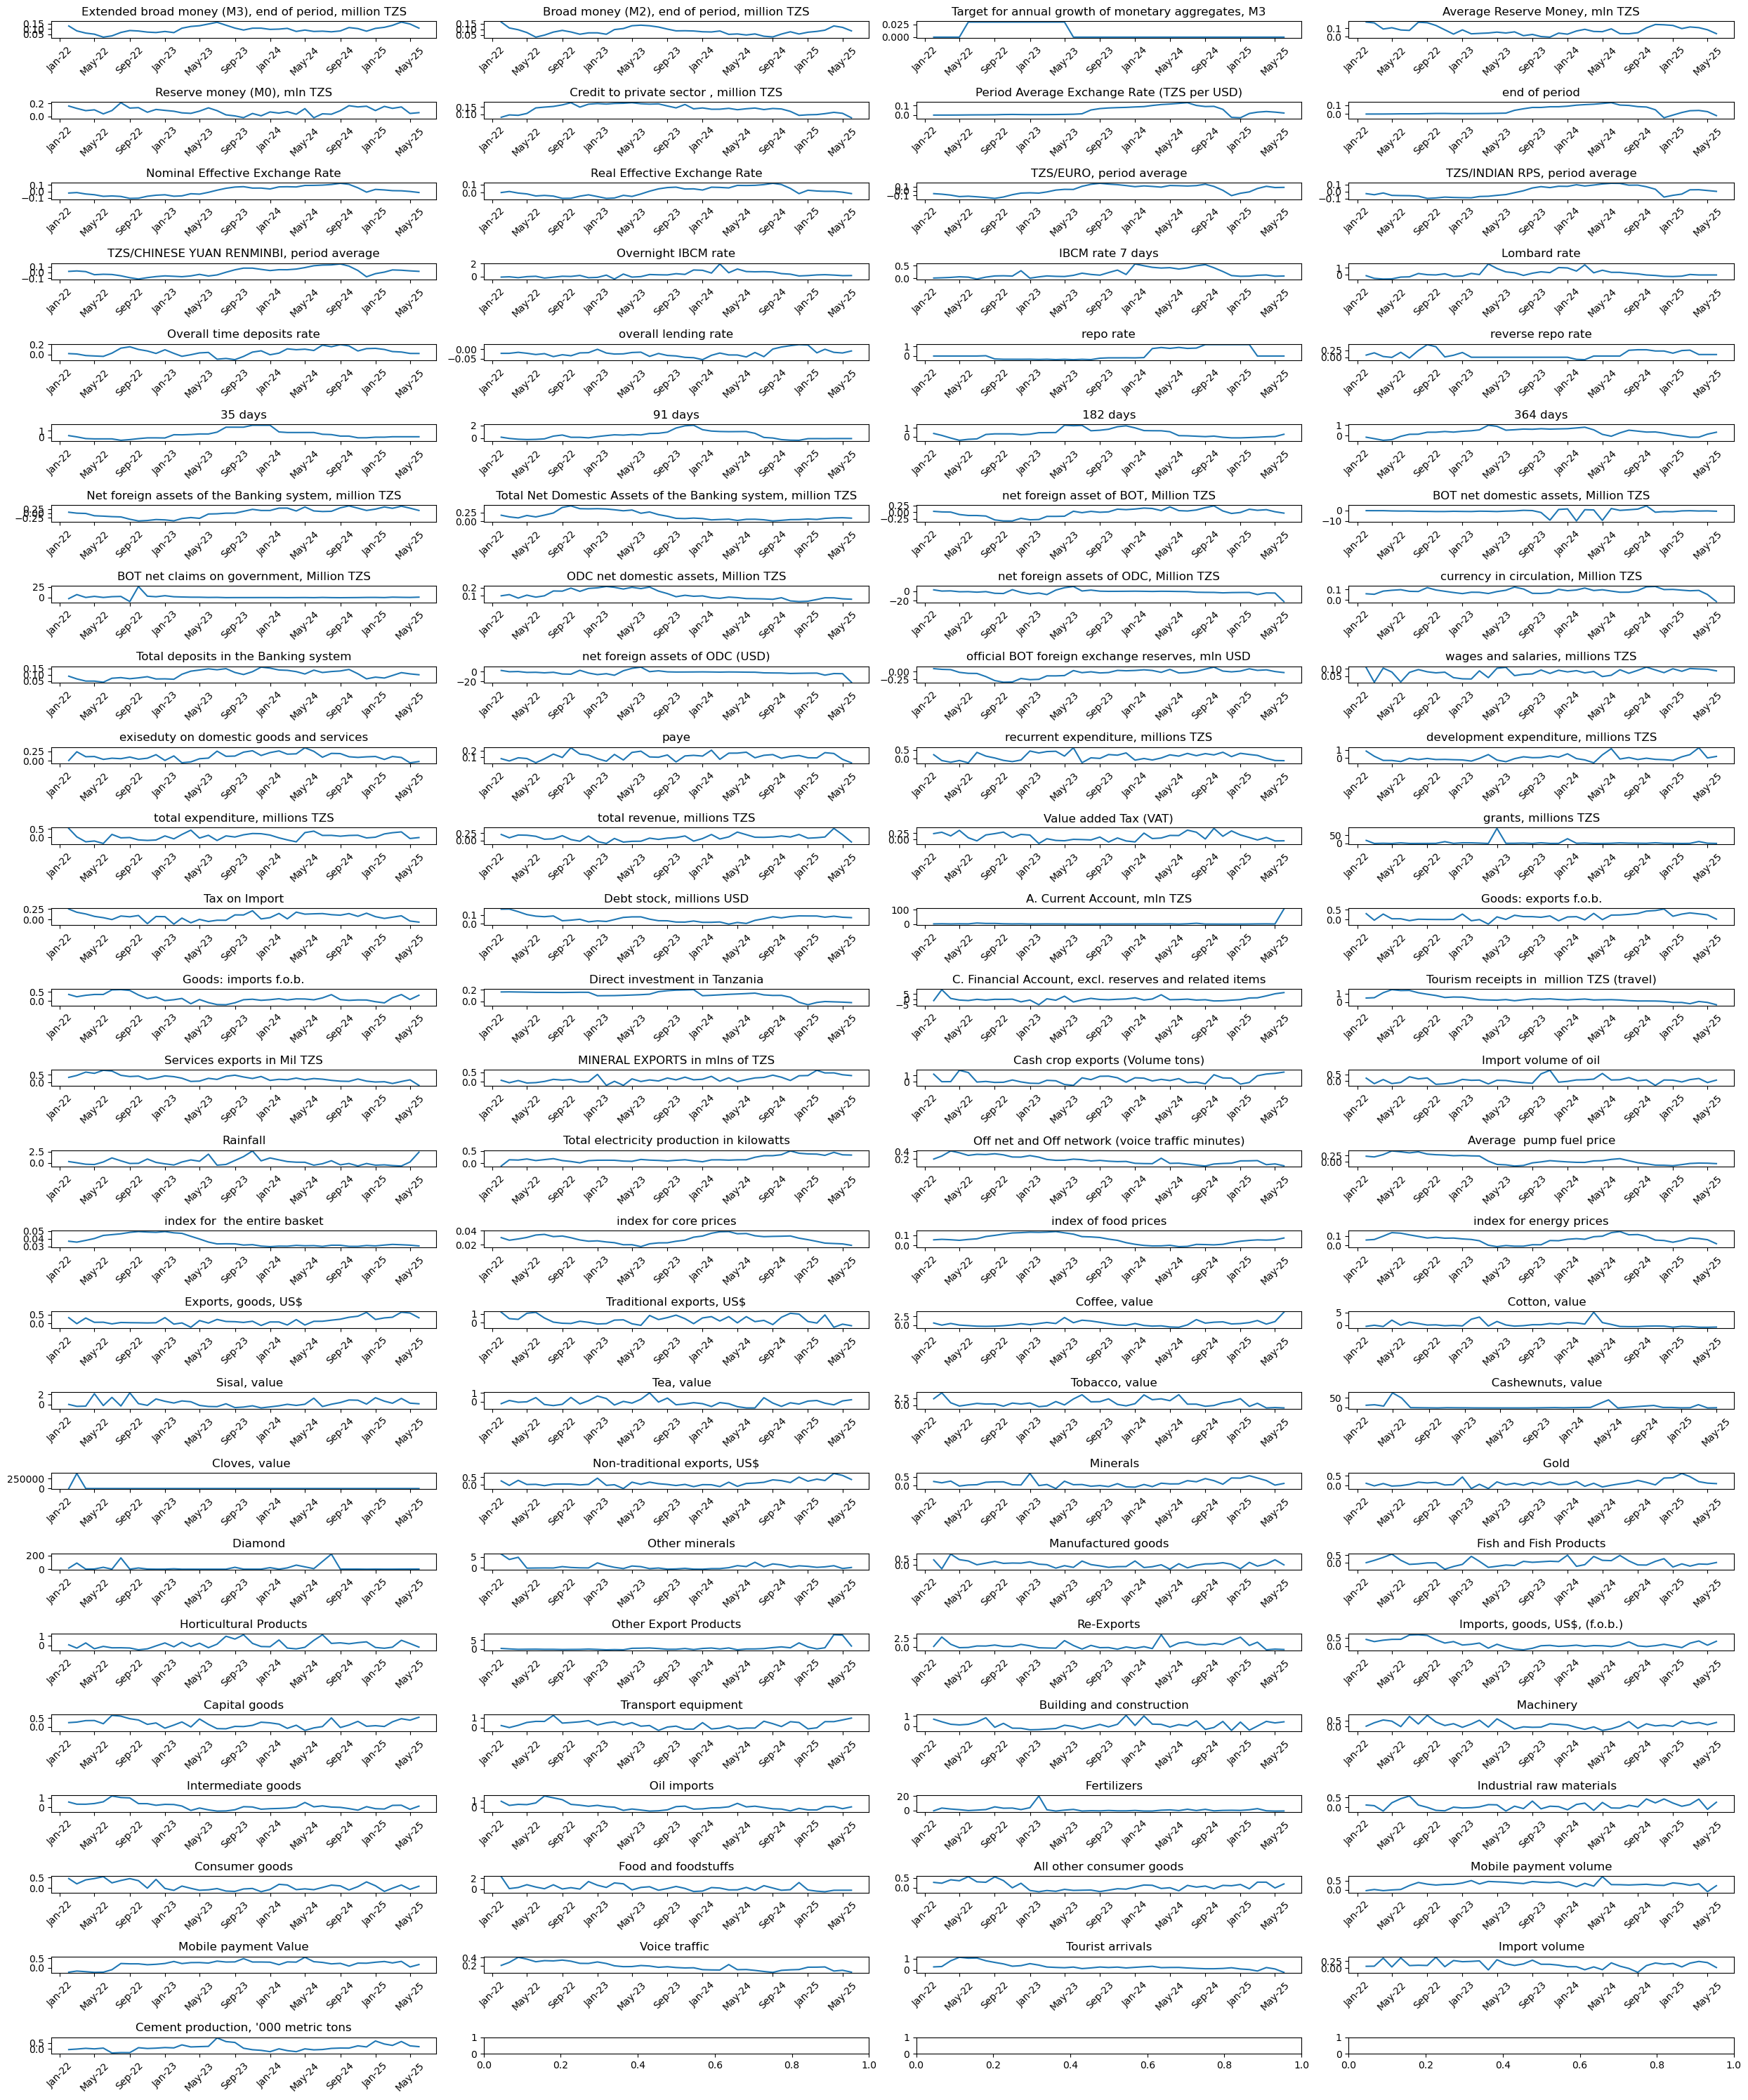

In [14]:

d12 = {}
for col in df1.columns[:]:
    d12[col] = df1[col].pct_change(periods=12)

d12 = pd.DataFrame(d12)
if generate_plots:
    lineplots(df1.columns[:], d12,ncols=4, plt_start="2022M1")


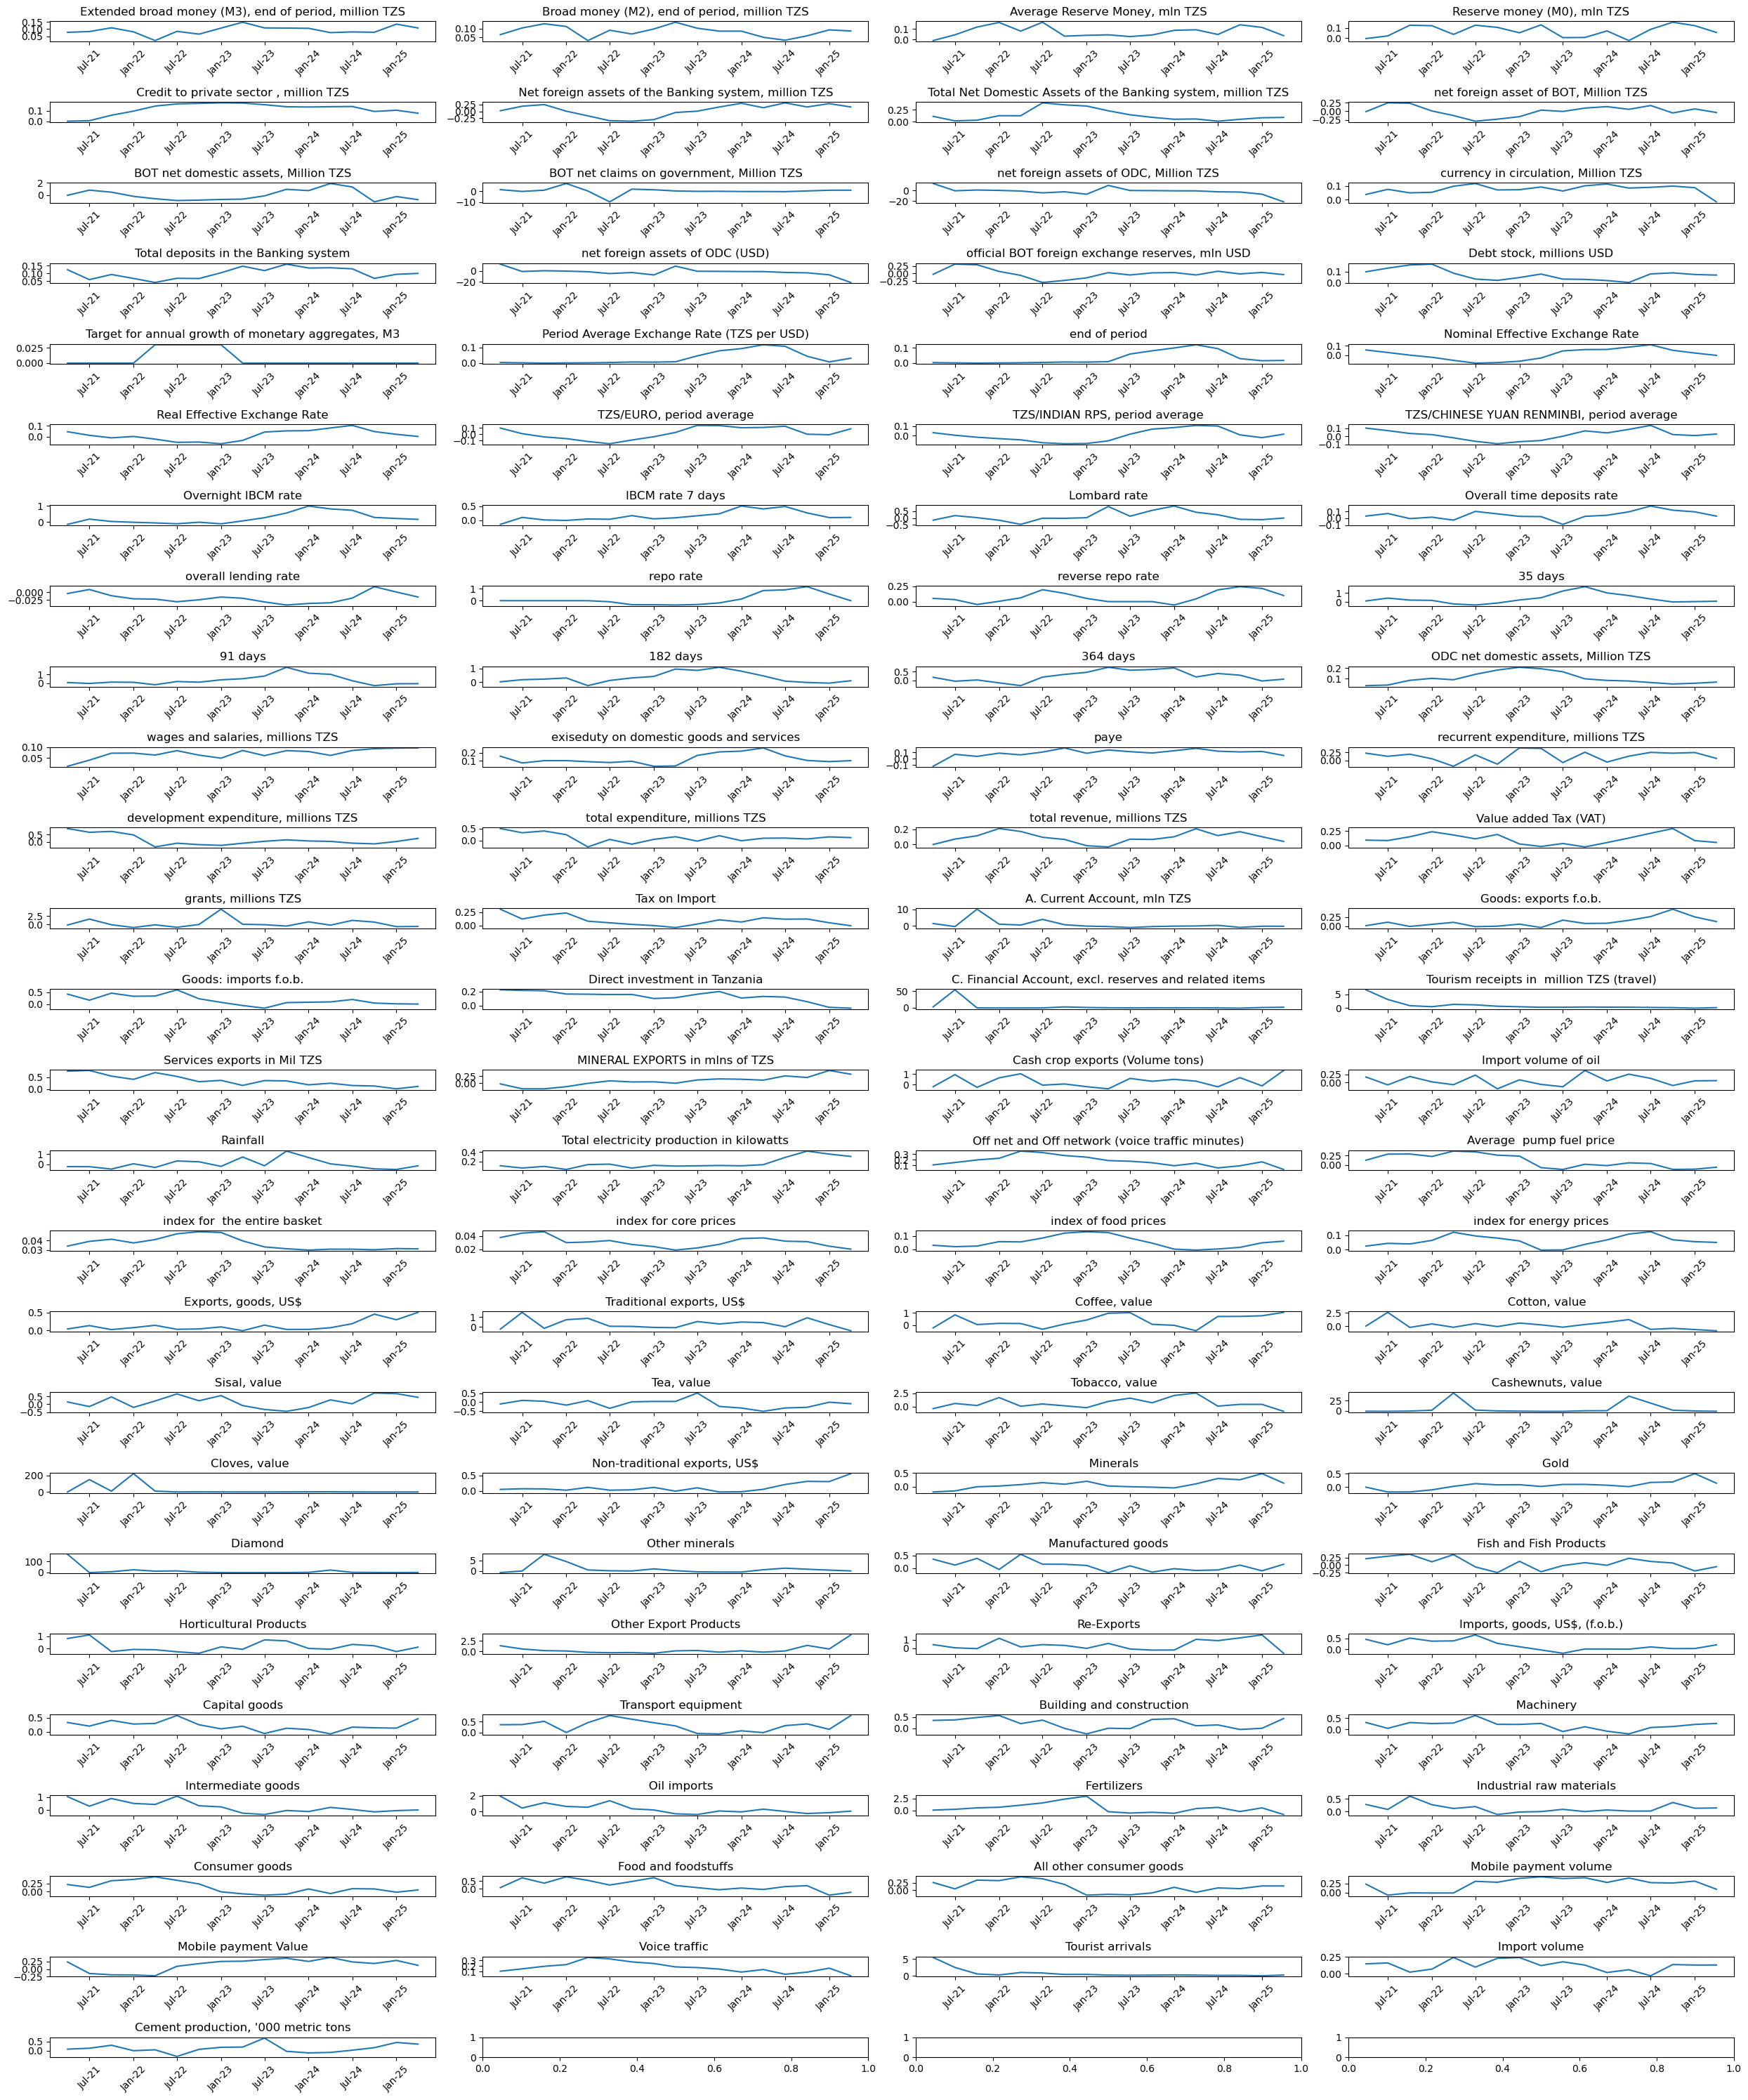

In [15]:
stock_vars = [k for k,v in m2q_method.items() if re.search('LAST', str(v))]
dfnq = df1.copy()
dfnq['yq'] = pd.PeriodIndex(dfnq.index, freq='Q')
flow_vars = [c for c in dfnq.columns if c not in stock_vars + ['yq']]
d1 = dfnq.groupby('yq')[stock_vars].last()
d2 = dfnq.groupby('yq')[flow_vars].mean()

dfnq = pd.concat([d1, d2], axis=1)

for col in dfnq.columns:
    dfnq[col] = dfnq[col].pct_change(periods=4)

dfnq.index = dfnq.index.to_timestamp()
vars = stock_vars + flow_vars
lineplots(vars, dfnq, plt_start="2021M1")

### Levels, Nominal deflated with CPI

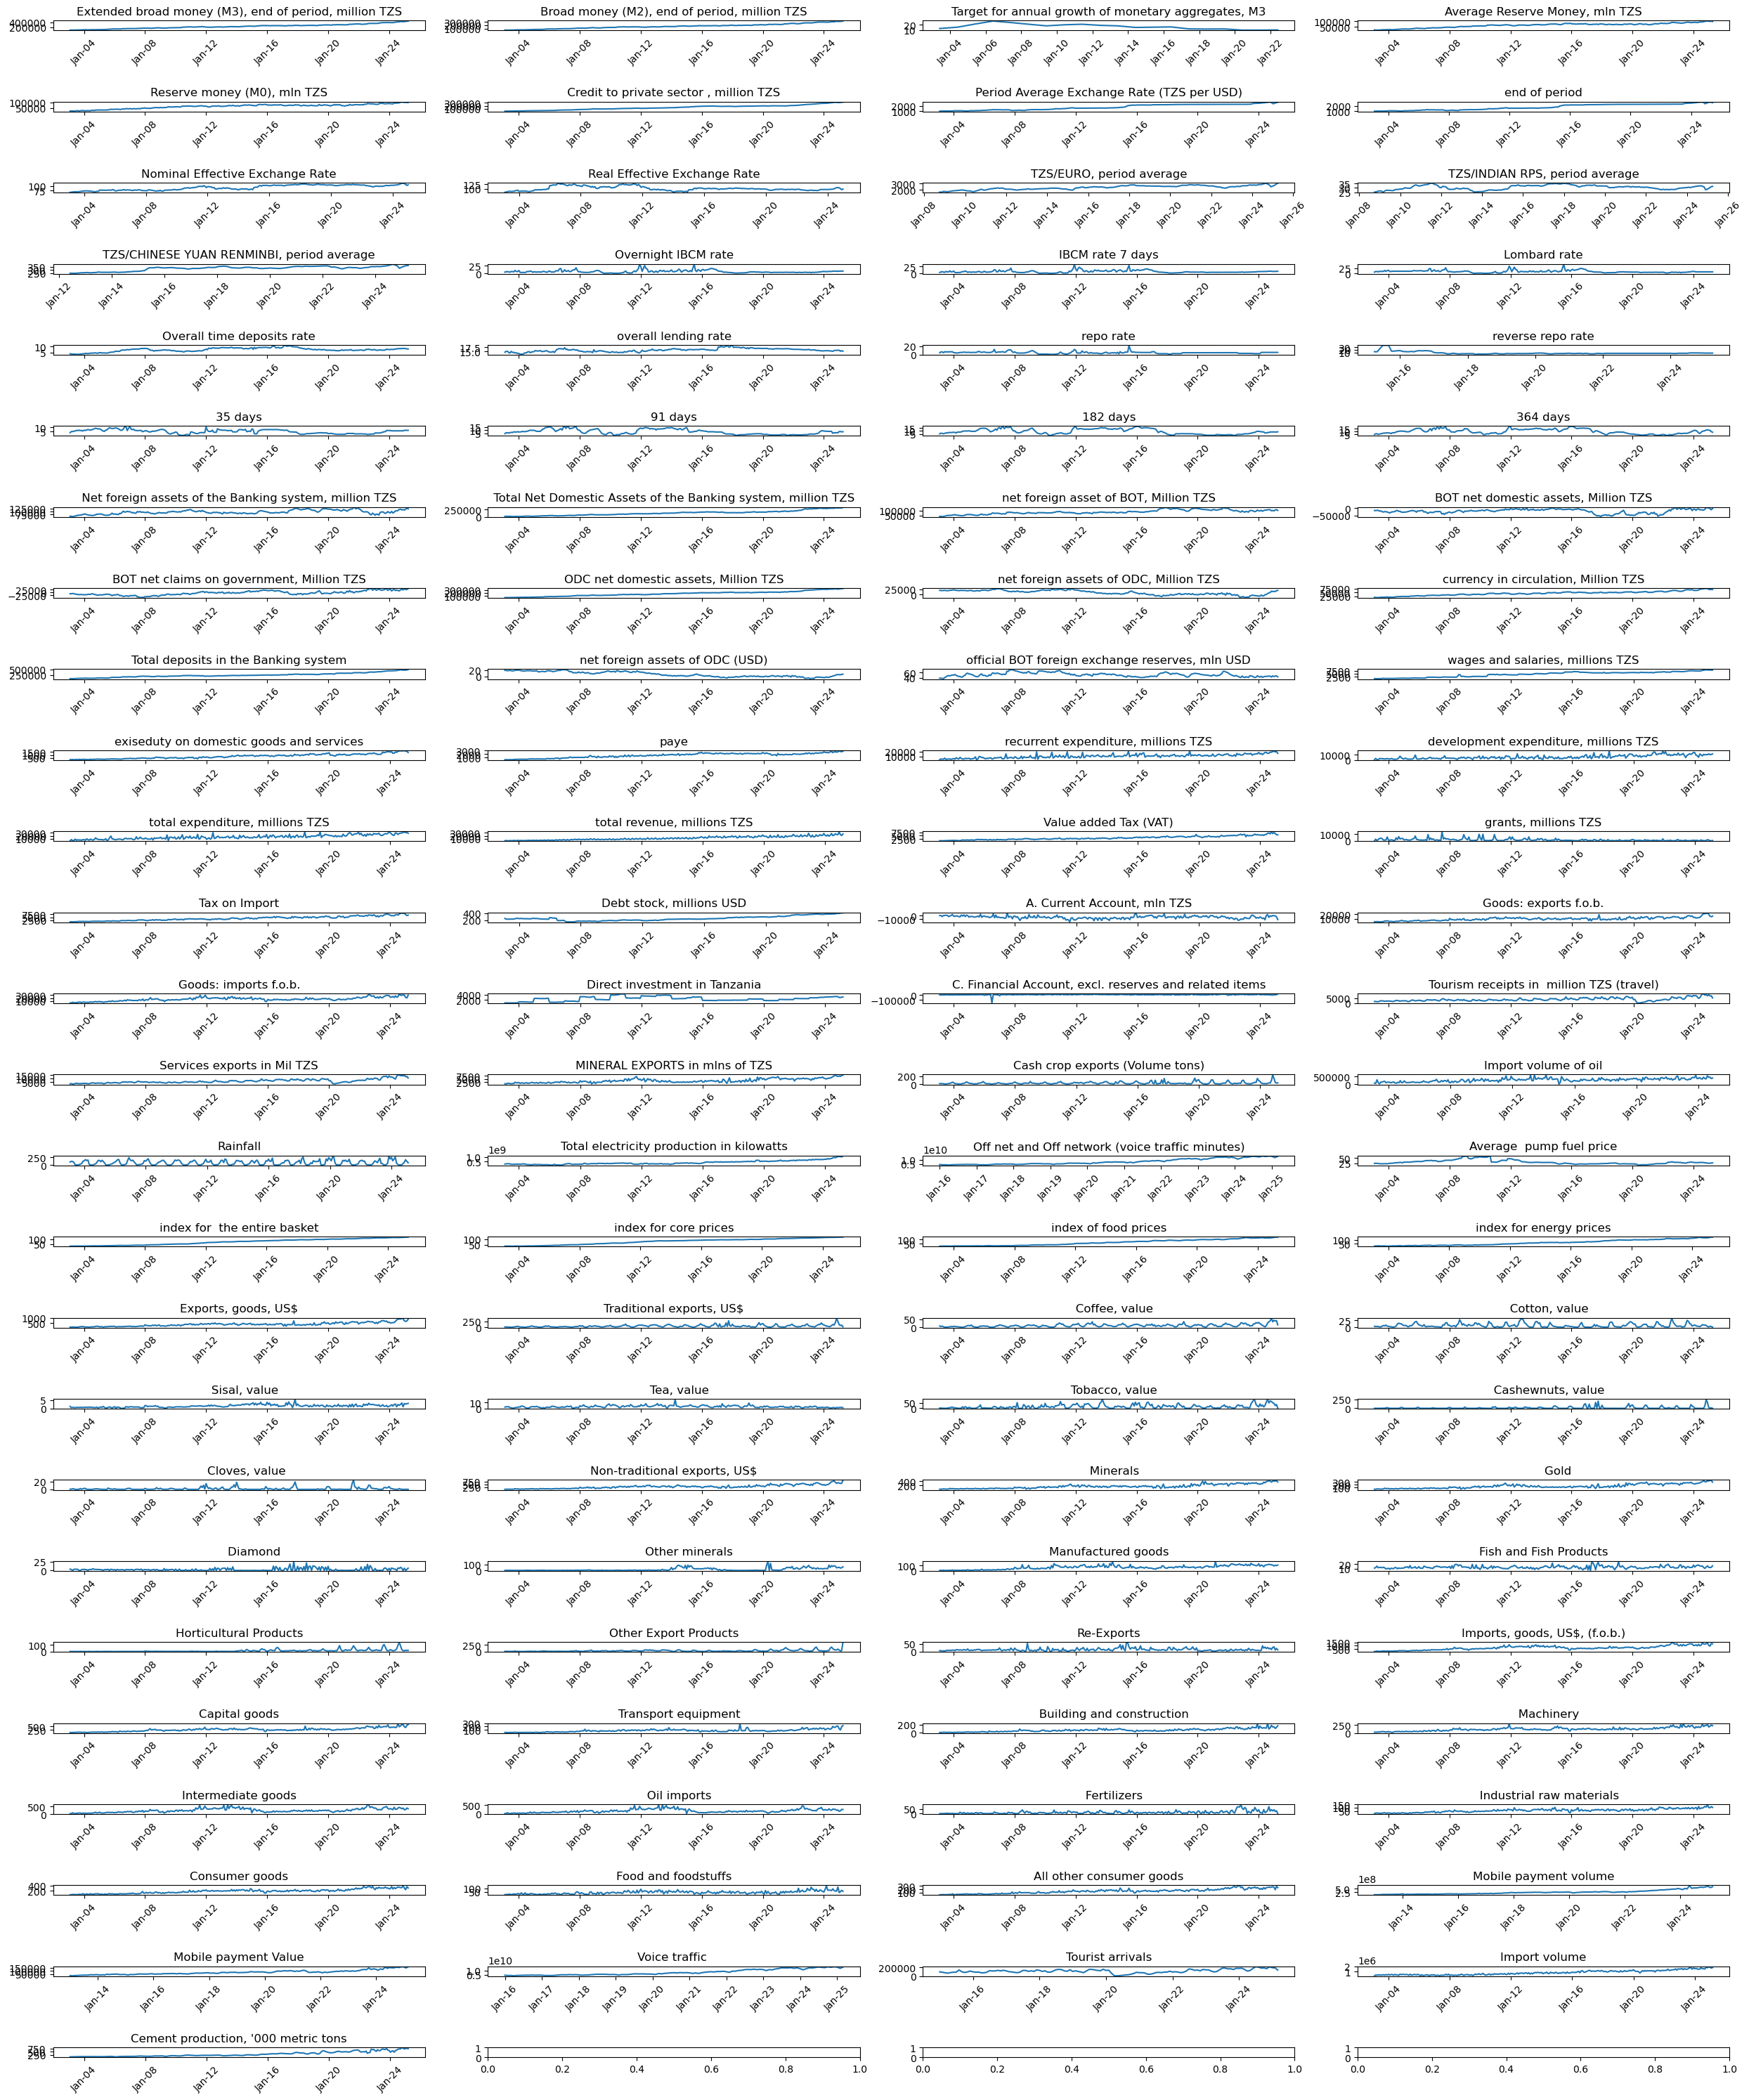

In [16]:
if generate_plots:
    vars = df1.columns
    lineplots(vars,df1)


# HP-filtering and Visualisation
 - This was done to reduce noise in data, However it dindn't improve the outcomes
 - We keep it for future use

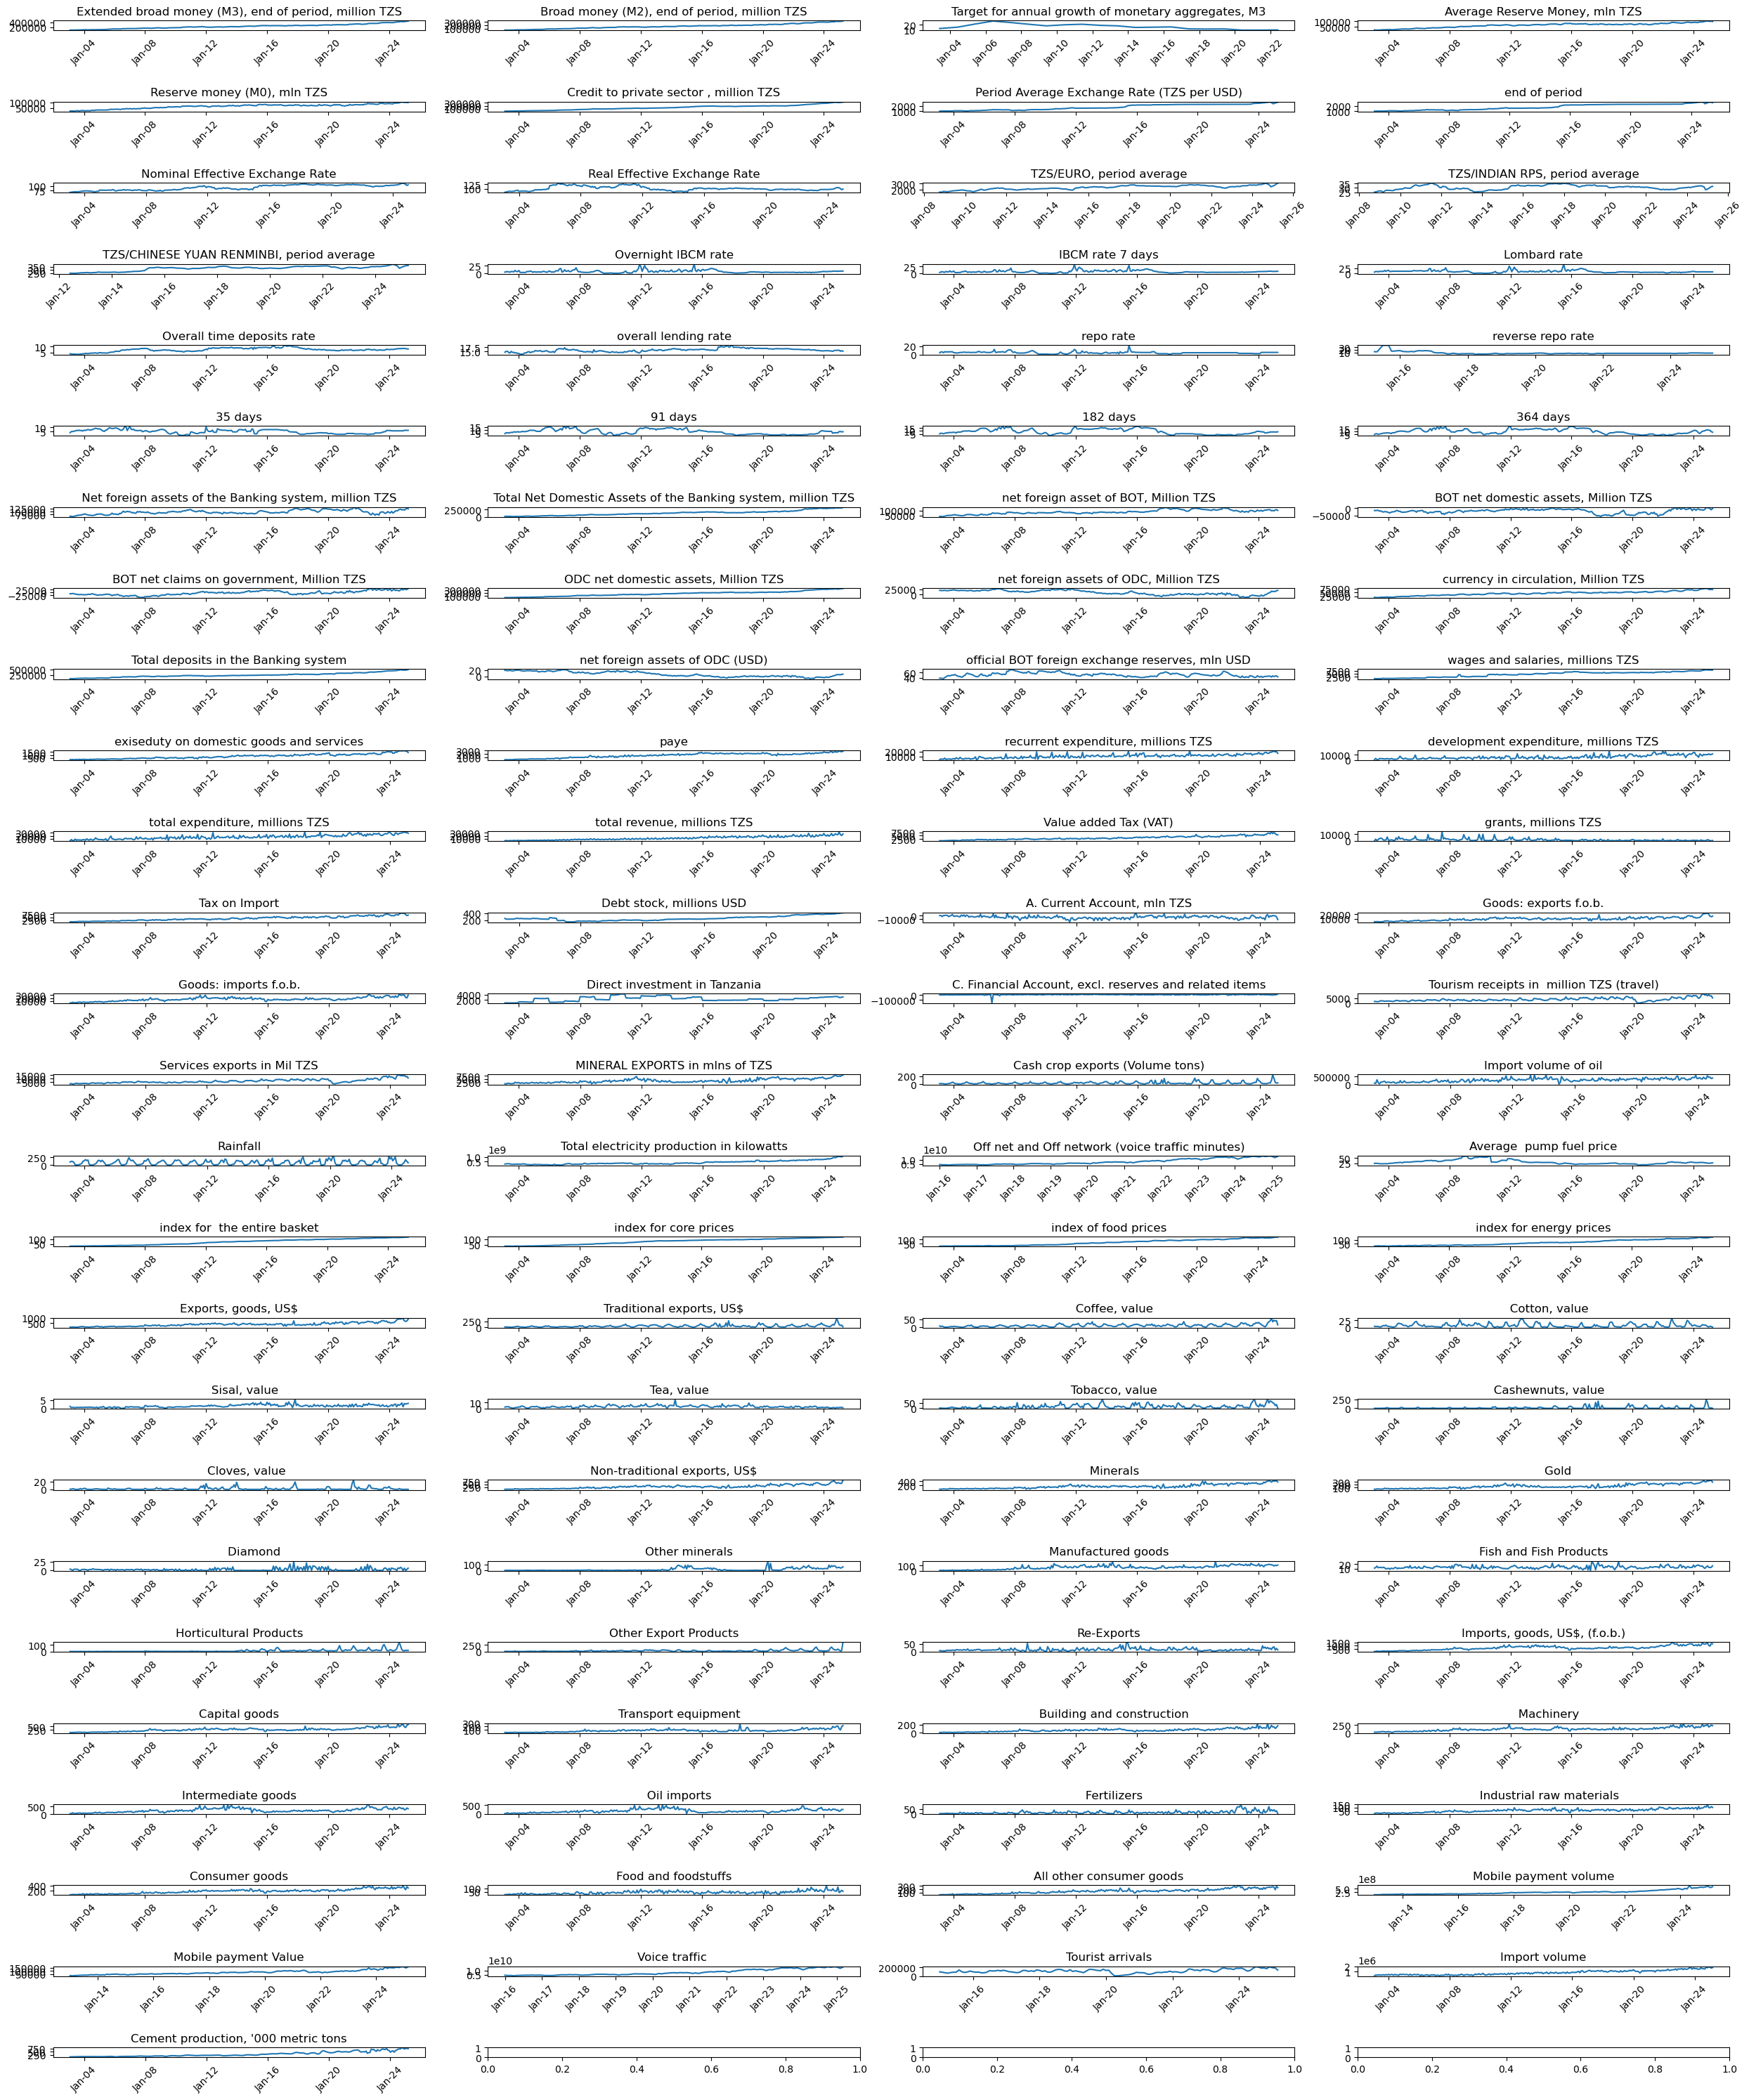

In [17]:

import pandas as pd
import statsmodels.api as sm

smooth_data = False

if smooth_data:
    for col in df1.columns:
        # print(col)
        try:
            cycle, trend = sm.tsa.filters.hpfilter(df1[col].dropna(), lamb=0.5)  # lambda=1600 for quarterly data, small lambda for smoothing
            df1[col] = trend
        except Exception as e:
            print(f"{col}: {e}")
            df1[col] = df1[col]

# Apply HP filter
if generate_plots:
    lineplots(vars,df1)

## Identify and remove outliers
 - Outliers are identified as values greater or less than 1.5*IQR (Interquatile Range)
 - Outliers are replaced with values equal to the corresponding period value

Outlier report
 ------------------------------------------------------------
REER_SU: ['2002Q1', '2006Q3']
TZSCNY_SU: ['2012Q2', '2012Q3', '2012Q3', '2012Q3', '2012Q4', '2012Q4', '2012Q4', '2013Q1', '2013Q1', '2013Q1', '2013Q2', '2013Q2', '2013Q2', '2013Q3', '2013Q3', '2013Q3', '2013Q4', '2013Q4', '2013Q4', '2014Q1', '2014Q1', '2014Q1', '2014Q2', '2014Q2', '2014Q2', '2014Q3', '2014Q3', '2014Q3', '2014Q4']
RNOV_SU: ['2006Q3', '2006Q4', '2007Q4', '2011Q4', '2011Q4', '2012Q1', '2012Q1', '2012Q2', '2012Q2', '2012Q2', '2014Q3', '2015Q2', '2015Q3', '2016Q3', '2016Q3', '2016Q3', '2016Q4']
RN_SU: ['2007Q4', '2011Q4', '2011Q4', '2012Q1', '2012Q1', '2012Q2', '2012Q2', '2012Q2', '2015Q2', '2015Q3', '2016Q3', '2016Q3', '2016Q4']
LOMB_SU: ['2006Q3', '2006Q4', '2007Q4', '2011Q4', '2012Q1', '2012Q1', '2012Q2', '2012Q2', '2015Q2', '2015Q3', '2016Q1', '2016Q2', '2016Q3', '2016Q3', '2016Q3', '2016Q4', '2016Q4', '2016Q4']
CRED_SU: ['2017Q3', '2017Q4']
REPO_SU: ['2006Q3', '2007Q3', '2007Q3', '2007Q3', '20

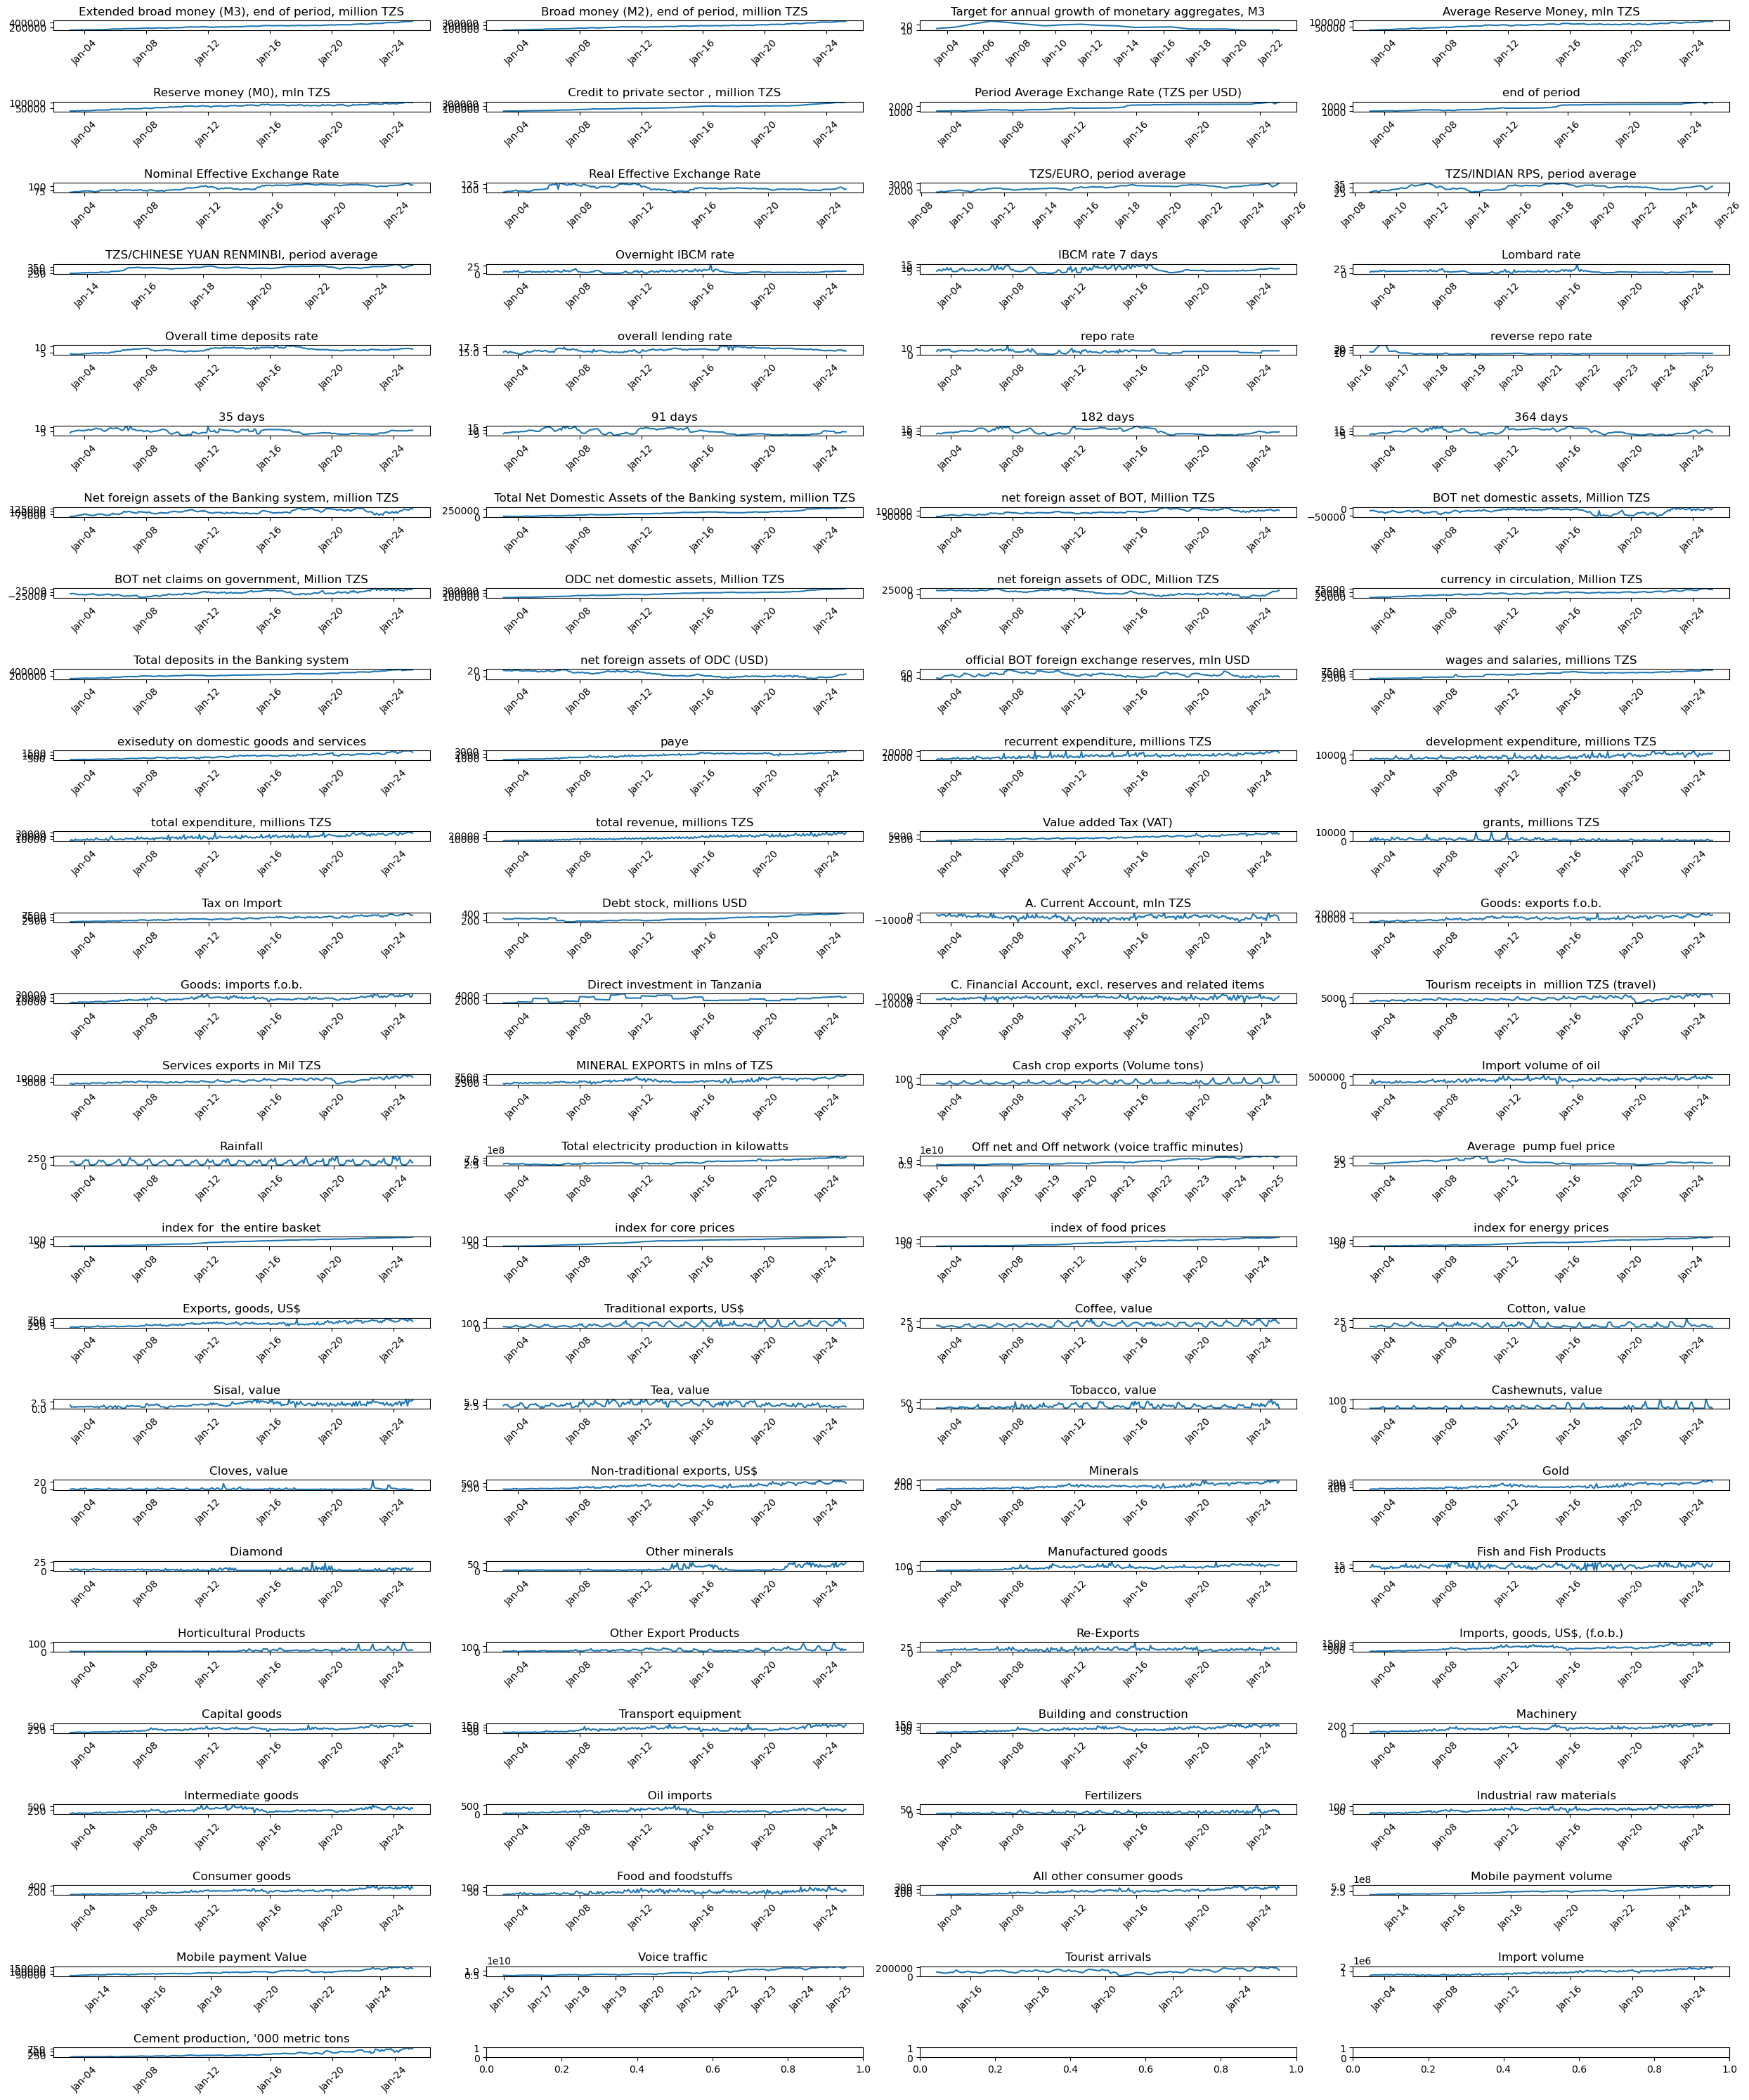

In [18]:
remove_outliers = True

if remove_outliers:
    def remove_outliers_iqr(data, columns):
        data = data.copy()
        print("Outlier report\n", "-"*60 )
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Find outliers
            outliers = (data[col] < lower_bound) | (data[col] > upper_bound)

            # Replace outliers with the previous (lagged) value
            data.loc[outliers, col] = data[col].shift(12)
            if data.loc[outliers, col].shape[0]:
                print(f"{col}: {list(pd.PeriodIndex(data.loc[outliers, col].index, freq='Q').astype(str))}")
        return data

df1 = remove_outliers_iqr(df1, df1.columns)

if generate_plots:
    lineplots(vars,df1)

# Seasonal adjustment
- Make sure you download the `x13as` file you can get it from [here](https://sourceforge.net/projects/gretl/files/x13as/)
- Set the correct path as shown in the cell below

In [19]:
import os
import warnings

from statsmodels.tsa.x13 import x13_arima_analysis
from statsmodels.tsa.x13 import X13Warning

warnings.filterwarnings("ignore", category=X13Warning)

# Set the correct path to your X13 executable
x13path = r"C:\x13as\x13as.exe"  # Use raw string (r prefix) for Windows paths
os.environ["X13PATH"] = x13path


try:
    # to_drop = ['Mobile payment volume','Mobile payment Value', 'Voice traffic', 'Tourist arrivals', 'Fuel prices']
    to_drop = ['Fuel prices']
    df1.drop(columns=to_drop, inplace=True)
except Exception as e:
    print(e)

try:
    # df1 = df1.set_index('Description', drop=False)
    df1 = df1.asfreq('MS')  # monthly start
except Exception as e:
    print(e)

# Seasonal adjustment
# df2 = df1.copy()
if do_sa:
    for col in df1.columns:
        try:
            # Pass the series data, not just column name
            series = df1[col].dropna()
            result = x13_arima_analysis(series, x12path=x13path)
            df1[f"sa_{col}"] = result.seasadj
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            df1[col] = df1[col]  # Keep original if adjustment fails

df1.head()

"['Fuel prices'] not found in axis"


M3_SU         M2_SU  TAR_SA         MB_SU        MB0_SU  \
date                                                                         
2002-01-01  67138.371523  45820.341811     NaN  20906.423635  20328.835370   
2002-02-01  68430.832740  45688.410334     NaN  20598.404548  19665.941947   
2002-03-01  68516.389317  45190.115262     NaN  19938.228609  18256.297473   
2002-04-01  67373.974247  44245.255262     NaN  19257.907080  19118.067143   
2002-05-01  66907.321956  43851.612546     NaN  20237.719529  19696.786839   

                  CPS_SU  PAVUSD_SU  TZSUS_SU    NEER_SU    REER_SU  ...  \
date                                                                 ...   
2002-01-01  19198.351568    924.700    936.00  54.665421        NaN  ...   
2002-02-01  19023.950154    955.620    970.50  56.156164  71.237777  ...   
2002-03-01  19508.597808    968.560    981.36  56.915785  72.965875  ...   
2002-04-01  18657.374044    978.520    965.99  56.939161  73.373064  ...   
2002-05-01  19257.616525    982.472    956.71  57.368734  74.494101  ...   

            bop_industrial_SU  bop_consumer_SU  bop_food_SU  \
date                                                          
2002-01-01          13.873470        37.977868    12.432663   
2002-02-01          14.333219        34.727076    10.355324   
2002-03-01          13.608977        34.081850    10.567907   
2002-04-01          13.208720        37.053222    12.812838   
2002-05-01          16.731778        44.446846    18.555080   

            bop_otherconsumer_SU  mobpay_vol_SU  mobpay_val_SU  mobvoice_SU  \
date                                                                          
2002-01-01             25.545205            NaN            NaN          NaN   
2002-02-01             24.371752            NaN            NaN          NaN   
2002-03-01             23.513943            NaN            NaN          NaN   
2002-04-01             24.240385            NaN            NaN          NaN   
2002-05-01             25.891766            NaN            NaN          NaN   

            tourist_arrival_SU  importvol_SU     CMT_SU  
date                                                     
2002-01-01                 NaN      232039.0  76.363746  
2002-02-01                 NaN      247251.0  74.021281  
2002-03-01                 NaN      320015.0  74.614973  
2002-04-01                 NaN      257775.0  78.144861  
2002-05-01                 NaN      236824.0  82.168623  

[5 rows x 101 columns]

## Compare SA and SU series

In [20]:
cols = df1.columns

if do_sa:
    def lineplots(df):
        ncols = 4
        fig, axs = plt.subplots(ncols=ncols, nrows= int(len(cols)*0.5)//ncols, figsize = (20,15))

        axs = axs.ravel()

        for ax, col in zip(axs, cols):
            sns.lineplot(data=df, x= df.index, y=col, label='su', ax=ax)
            sns.lineplot(data=df, x= df.index, y=f"sa_{col}", label='sa', ax=ax)
            ax.set_title(col)
        plt.tight_layout()    

    lineplots(df1)

# Variable selection

In [21]:
# Create column  `yq` to capture quartely dates, for merging with GDP
try:
    df1['yq'] = df1.index.to_period('Q')
except Exception as e:
    print(f"{e}")

# stock_vars = ['Credit to private sector', 'M3', 'Total deposits in the Banking system']  # Example end-of-quarter variables
flow_vars = [c for c in df1.columns if (c not in stock_vars) and not (re.search(r"(?i)description", str(c)))]


#  Aggregate by mean 
mean_df = df1.groupby('yq')[flow_vars].mean()

#  Aggregate by end-of-quarter (last observation per quarter) 
last_df = df1.groupby('yq')[stock_vars].last()

# Merge both results
dfq = pd.concat([mean_df, last_df], axis=1)
dfq = pd.concat([dfq, gdp.loc[:,'GDP']], axis=1)

# seasonally adjust GDP
if do_sa:
    series = dfq['GDP'].dropna()
    result = x13_arima_analysis(series,x12path=x13path)

    dfq[f'sa_GDP Actual'] = result.seasadj

# drop yq from dfq

In [22]:
try:
    dfq.drop(columns=['yq'], inplace=True)
except Exception as e:
    print(e)

In [23]:
# Identify short time series
many_missing_values = []
for col in dfq.columns:
    if dfq[col].isna().mean()>0.4:
        many_missing_values.append(col)
        # print(col)
df1[many_missing_values]
print(many_missing_values)

df1_short_series = df1[many_missing_values]


['TAR_SA', 'TZSCNY_SU', 'REVREPO_SU', 'voice_SU', 'mobpay_vol_SU', 'mobpay_val_SU', 'mobvoice_SU', 'tourist_arrival_SU']


# PRINCIPAL COMPONENTS ANALYSIS
 - PCA on all indicators for dimensionality reduction
 - However, PCA on all variables did not help to improve the results

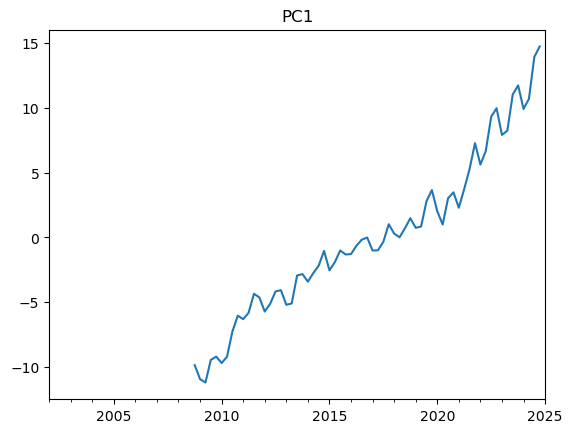

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

to_drop = ['ph_SU'] + many_missing_values

X = df1.select_dtypes(include='number').drop(columns=to_drop)
# for col in X.columns:
#     X[col] = X[col].pct_change(1)
X = X.dropna()
scaler = StandardScaler()
scaler = scaler.fit(X)
X_scaled = scaler.transform(X)

# from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(X=X_scaled)


np.round_(pca.explained_variance_ratio_,3)

# for i,j in enumerate(pca.explained_variance_ratio_):
#     print(f"PC{i+1}: {pca.explained_variance_ratio_[i]}")

# Obtain principle component scores
pcs = pca.transform(X_scaled)
pc = pd.DataFrame(pcs, columns=['PC1', 'PC2'])
pc.index = X.index

# Add principal components to data
df1 = pd.concat([df1, pc], axis=1)
pc['yq'] = pd.PeriodIndex(pc.index, freq='Q')
qpc = pc.groupby('yq').mean()

qpc = pd.concat([qpc, gdp], axis=1)

qpc['PC1'].plot(title='PC1', xlabel='')
plt.show()


## Elastic net
 - Elastic net algorithm is used for selection of variables
 - It combines LASSO (L1) and Ridge regression (L2). Lasso shrinks the coefficients of weak predictors while Ridge regression penalizes large coefficients which mostly results from multicollinearity.
 $$
\min_{\beta_0, \beta} \left( \frac{1}{2n_{\text{samples}}} \|y - X\beta - \beta_0\mathbf{1}\|^2_2 + \alpha \left( (1 - \text{L1}) \frac{1}{2} \|\beta\|^2_2 + \text{L1} \|\beta\|_1 \right) \right)
$$

$$
\text{L2} = 1 - \text{L1}
$$

$\alpha$ is the regularization parameter that control the overall strength of regularization, high values imply strict regularization and a more parsimonious model

In [25]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

#****************************
use_lags = False
#****************************

lags = {}
max_lag = 2

if use_lags:
    for col in stock_vars:
        for i in range(max_lag):
            lags[f"lag{i+1}_{col}"] = dfq[col].shift(i)

    dflags = pd.DataFrame(lags)
    dfq1 = pd.concat([dfq, dflags], axis=1)

    dfq = dfq1




try:
    dfq.drop(columns=many_missing_values,  inplace=True)
    dfq.dropna(inplace=True)
except Exception as e:
    print(f"Error: {e}")

# Define predictors and target
sa_series = [c for c in dfq.columns if re.search(r"sa_", str(c))]
su_series = [c for c in dfq.columns if not re.search(r"sa_", str(c))]
su_series = su_series[:]



if do_sa:
    X = dfq[sa_series].drop(columns=['sa_ph_SU','sa_GDP'])
    y = np.log(dfq['sa_GDP'])
    # y = (dfq['sa_GDP Actual'] - np.mean(dfq['sa_GDP Actual']))/np.std(dfq['sa_GDP Actual'])
else:
    X = dfq[su_series].drop(columns=['ph_SU','GDP'])
    y = np.log(dfq['GDP'])

#***********************************
use_growth = True
#***********************************

if use_growth:
    if do_sa:
        periods =1
    else:
        periods = 4 # For yoy quarterly changes we use 4, mom we use 1
    for col in X.columns:
        X[col] = X[col].pct_change(periods=periods)
    # for col in X.columns:
    #     X[col] = np.log(X[col])
    X = X.dropna()
    invalid = [c for c in X.columns if any(abs(X[c])>1e3)]
    X = X.drop(columns=invalid)
    y = y.pct_change(periods=periods)
    y = y.dropna()
    # y = np.log(y)
    X_scaled = X
else:
    invalid = [c for c in X.columns if any(abs(X[c])>1e3)]
    X = X.drop(columns=invalid)
# scale the variables
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X_scaled = scaler.transform(X)


# Fit Elastic Net model
alpha = 0.000019  # Controls overall regularization strength
l1_ratio = 0.4   # Balance between L1 (Lasso) and L2 (Ridge): 0=Ridge, 1=Lasso, 0.5=Equal mix

elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
elastic_net.fit(X_scaled, y)

# Extract coefficients and features
coef = pd.Series(elastic_net.coef_, index=X.columns)

# Keep only non-zero features (selected)
selected_features = coef[coef > 0].sort_values()
selected_features = selected_features.index.to_list()

#************************************************************************
# Override with manually selected features
if select_vars_manually and use_custom_weights:
    selected_features = manual_vars
    # check if all features have weights
    if all([c in custom_weights.keys() for c in manual_vars]):
        print('All manually selected variables are assigned weights')
    else:
        print("Assign weights to all variables")
#************************************************************************

print("Selected features:")
print(selected_features)

# Optional: Print model performance metrics
print(f"\nElastic Net Model Info:")
print(f"Alpha (regularization strength): {alpha}")
print(f"L1 ratio: {l1_ratio}")
print(f"Number of selected features: {len(selected_features)}")
print(f"Total features: {len(X.columns)}")

Selected features:
['ODNFA_SU', 'budgdev_SU', 'bop_cotton_SU', 'bop_oil_SU', 'bop_fertilizer_SU', 'bop_othermineral_SU', 'bop_hortic_SU', 'bop_sisal_SU', 'bop_reexport_SU', 'NDA_SU', 'bop_trad_SU', 'nfatot_SU', 'LOMB_SU', 'RNOV_SU', 'bop_manufa_SU', 'taxim_SU', 'bop_coff_SU', 'bop_tea_SU', 'gold_SU', 'importvol_SU', 'servicesexp_SU', 'PUMP_SU', 'budgrevtot_SU', 'bop_build_SU', 'TZSEURO_SU']

Elastic Net Model Info:
Alpha (regularization strength): 1.9e-05
L1 ratio: 0.4
Number of selected features: 25
Total features: 89


In [26]:
# for c in X.columns:
#     if any(abs(X[c])>1e2):
#         print(f"Min: {np.min(X[c])}, Max: {np.max(X[c])}")



### add lags to data if needed

In [27]:
# Add lagged variables to df1
lags = {}

if use_lags:
    for col in stock_vars:
        for i in range(max_lag):
            lags[f"lag{i+1}_{col}"] = df1[col].shift(i+1)

    dflags = pd.DataFrame(lags)
    df1 = pd.concat([df1, dflags], axis=1)

##  Compute mom symmetric change 
$$
\Delta M_t = 200\times \frac{X_t - X_{t-1}}{X_t + X_{t-1}}
$$

In [28]:

sa_cols = [c for c in selected_features if not re.search(r'(?i)gdp', c)] #+ ['sa_Total  Expenditure', 'sa_Import Value']
su_cols = [c for c in selected_features if not re.search(r'(?i)gdp', c)] + ['mobpay_val_SU']
# su_cols = [c for c in df1.columns[2:] if not re.match(r"^sa_",str(c))]

#*************************************************************************************************************
# Override with manual features

#*************************************************************************************************************
mom_change = {}
if do_sa:
    for col in sa_cols:
        mom_change[col] = 200*((df1[col]-df1[col].shift(1))/(df1[col]+df1[col].shift(1)))
else:
    for col in su_cols:
        mom_change[col] = 200*((df1[col]-df1[col].shift(1))/(df1[col]+df1[col].shift(1)))
mom_change = pd.DataFrame(mom_change)
dfchng = mom_change
# dfchng = pd.concat([df['Description'], mom_change], axis=1)
# dfchng

# Symmetric percentage changes - Visualization
 - Only selected variables are shown

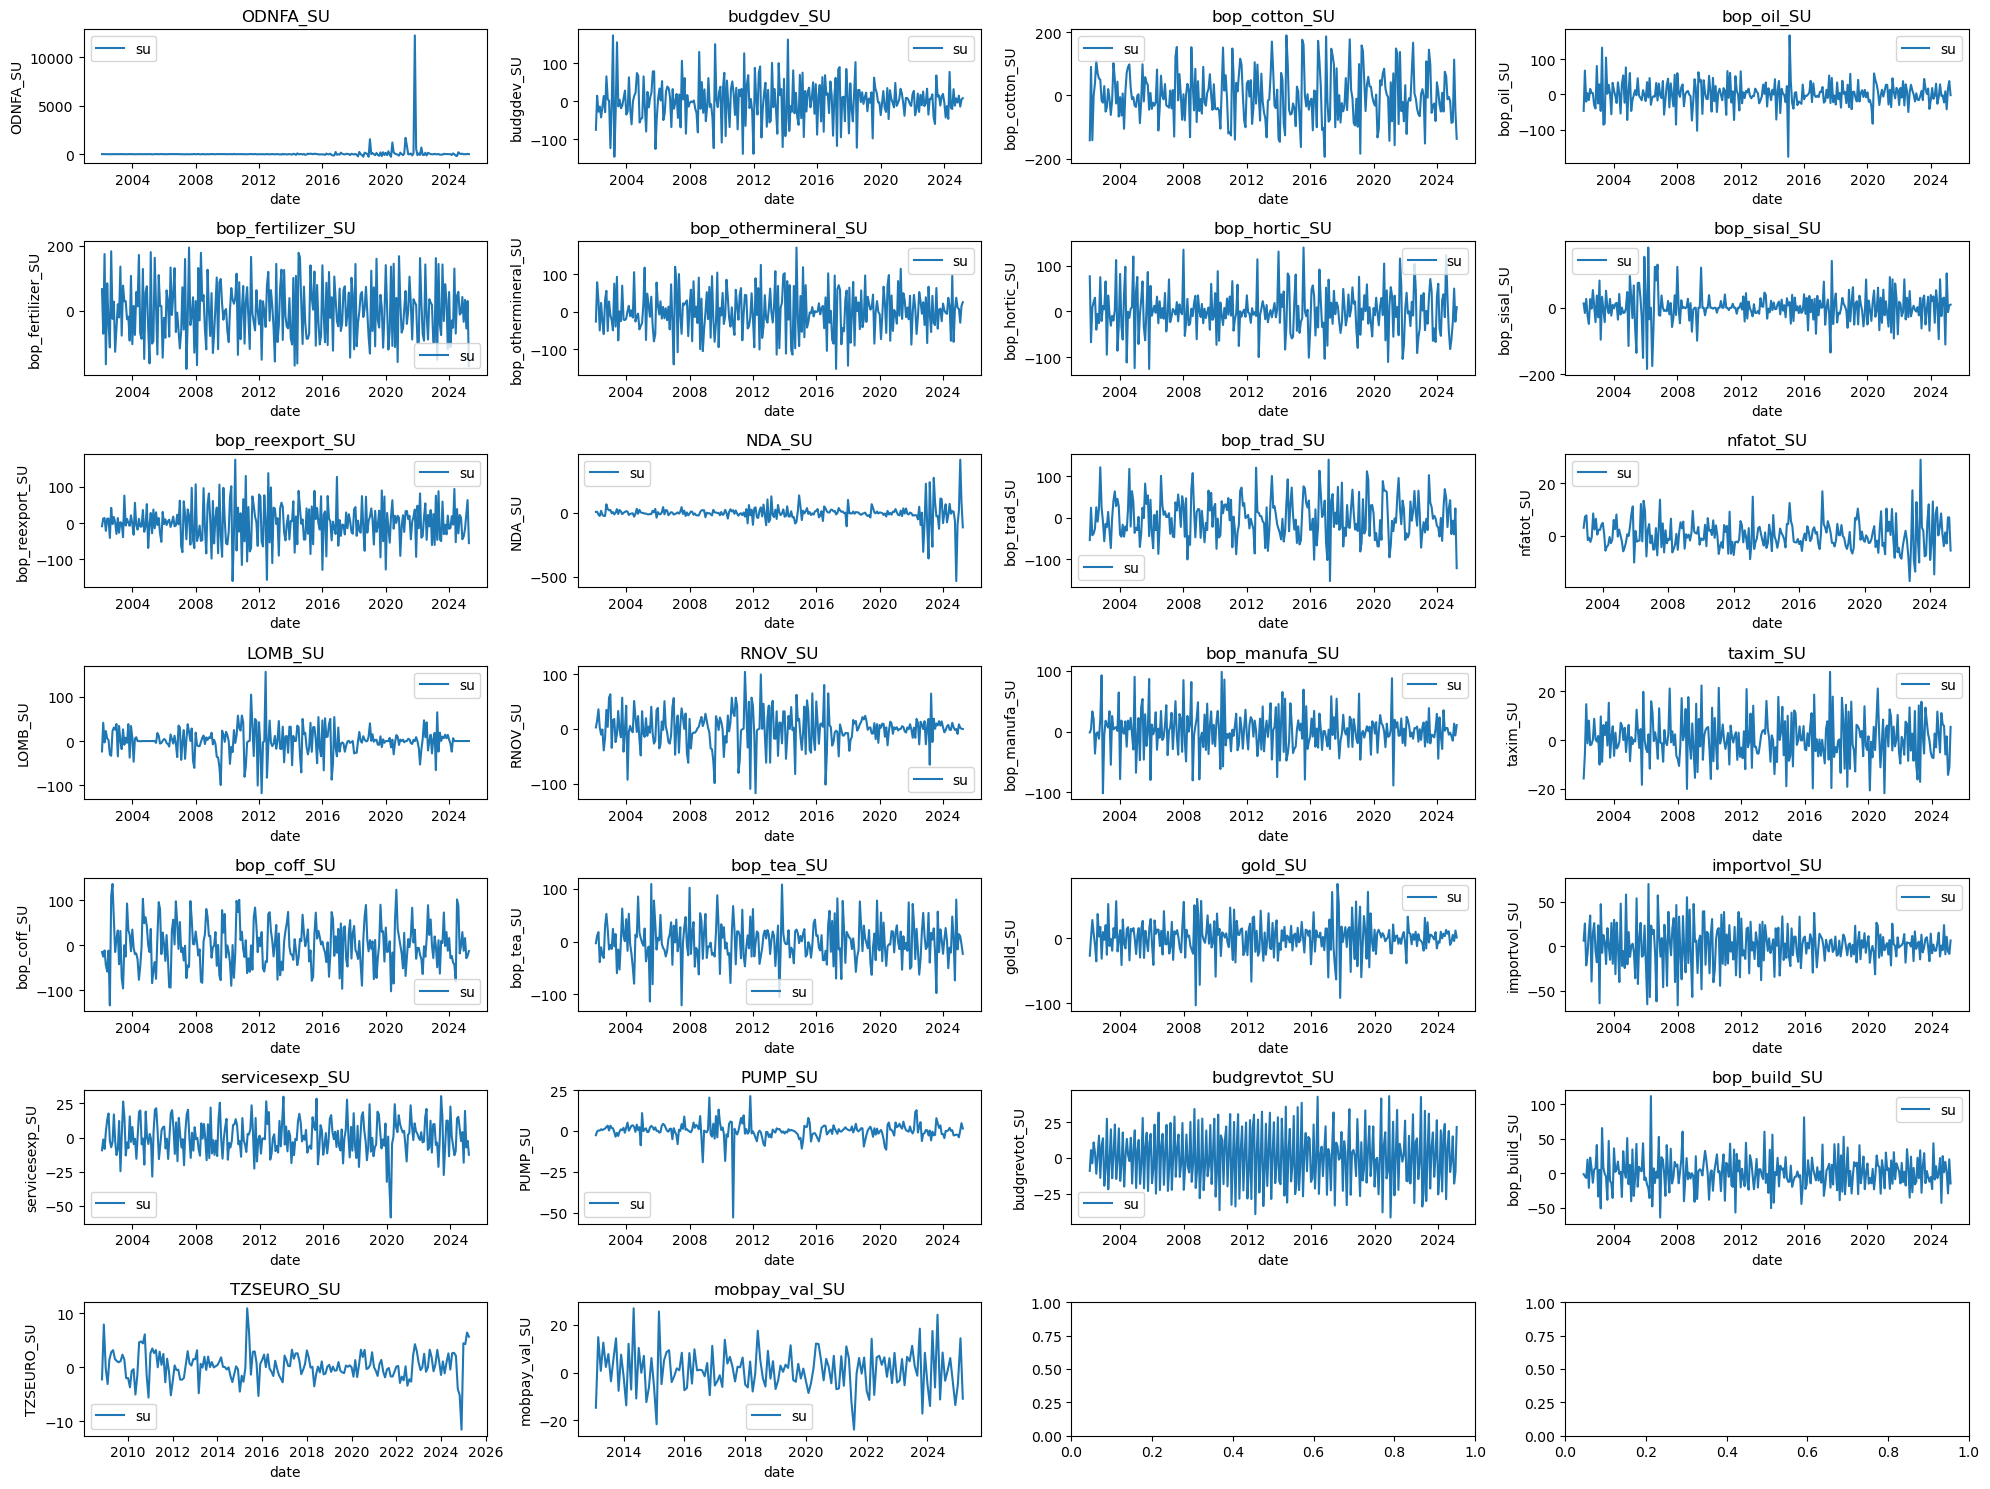

In [29]:
cols = dfchng.columns

def lineplots(df):
    ncols = 4
    fig, axs = plt.subplots(ncols=ncols, nrows= 1+int(len(cols))//ncols, figsize = (20,15))

    axs = axs.ravel()

    for ax, col in zip(axs, cols):
        sns.lineplot(data=df, x= df.index, y=col, label='su', ax=ax)
        # sns.lineplot(data=df, x= df.index, y=f"sa_{col}", label='sa', ax=ax)
        ax.set_title(col)
    plt.tight_layout()    
if generate_plots:
    lineplots(dfchng)

### Compute inverse standard deviations
- We use last 68 months for computation of standard deviation to reflect volatility in recent years

In [30]:

inv_sd = {}
for col in dfchng.columns:
    inv_sd[col] = 1/np.std(dfchng[col][-68:-1])#[-120:-1])

# Normalize sd weights 
inv_sd_sum = sum(inv_sd.values())
inv_sd_normalized = {}
for k,v in inv_sd.items():
    inv_sd_normalized[k] = v/inv_sd_sum

inv_sd_normalized

{'ODNFA_SU': 0.00038108163341066926,
 'budgdev_SU': 0.021836388791306928,
 'bop_cotton_SU': 0.007591788783412529,
 'bop_oil_SU': 0.022373982897357873,
 'bop_fertilizer_SU': 0.006549430029986938,
 'bop_othermineral_SU': 0.012611224579480051,
 'bop_hortic_SU': 0.011245746194826612,
 'bop_sisal_SU': 0.011891633050762926,
 'bop_reexport_SU': 0.012675045273169778,
 'NDA_SU': 0.0045273749359114835,
 'bop_trad_SU': 0.012458959697225633,
 'nfatot_SU': 0.07322016148187337,
 'LOMB_SU': 0.03191723739971006,
 'RNOV_SU': 0.03670349766188462,
 'bop_manufa_SU': 0.02528697631171002,
 'taxim_SU': 0.06427930316130642,
 'bop_coff_SU': 0.013194011829083196,
 'bop_tea_SU': 0.015920860114503856,
 'gold_SU': 0.04613897220011935,
 'importvol_SU': 0.049718547438989694,
 'servicesexp_SU': 0.03853273517091548,
 'PUMP_SU': 0.14461557134978653,
 'budgrevtot_SU': 0.027219540055103037,
 'bop_build_SU': 0.030149642496830477,
 'TZSEURO_SU': 0.21525919210187625,
 'mobpay_val_SU': 0.06370109535945612}

### Multiplying symetic change for each variable with its weight based on inverse `sd`

$$
\Delta m_{i,t} = \frac{1}{\sigma} \times \Delta M_{i,t}
$$

In subsequent steps these will be summed to obtain CIEA
$$
CIEA_t = \sum_{i=1,t}^{p} \Delta m_{i,t}
$$

Where $p$ is the number of variables


In [31]:
dfchng_adj = {}
for col in dfchng.columns:
    dfchng_adj[col] = inv_sd_normalized[col]*dfchng[col]

dfchng_adj = pd.DataFrame(dfchng_adj)
# dfchng_adj

# Optimising weights

In [32]:
# Import weight optimizer from module codes
from codes.ciea_weight_optimizer import WeightOptimizer

In [33]:
# DE Optimization
# ===============================================
use_de_optimisation = False # Whether to use DE algorithm

if use_de_optimisation:
    print("Basic DE Optimization")
    print("-" * 40)

    # Initialize the optimizer
    optimizer_de = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)

    # Method 1: Scipy optimization (recommended for most cases)
    print("Running DE optimization...")
    result_de = optimizer_de.optimize_weights_differential_evolution()

    # Get results
    optimal_weights_de = optimizer_de.get_optimal_weights()
    optimal_correlation_de = -result_de.fun
    print('_'*60)
    print(f"Optimal correlation: {optimal_correlation_de:.2f}")

In [34]:
# optimal_weights_de.keys()

In [35]:
def gen_weights_table(weight_dict):
    df = pd.DataFrame(weight_dict, index=[0]).T
    # dfw_de = dfw_de.T
    df.columns = ['weight']
    df.sort_values('weight', ascending=False, inplace=True)
    return df
if use_de_optimisation:    
    dfw_de = gen_weights_table(optimal_weights_de)
# dfw_de

In [36]:
if use_de_optimisation:
    qciea = optimizer_de.get_ciea_with_optimal_weights()
# qciea

## Optimized weights applied - DE

In [37]:
from codes.cieaplot import cieaplot
if use_de_optimisation:
    cieaplot(qciea)

## Composite indicator with equal weights

In [38]:
dfchng_adj

ODNFA_SU  budgdev_SU  bop_cotton_SU  bop_oil_SU  \
date                                                          
2002-01-01       NaN         NaN            NaN         NaN   
2002-02-01  0.002986   -1.644559      -1.077651   -1.047654   
2002-03-01  0.001385    0.317384       0.688325    1.522569   
2002-04-01 -0.000933   -0.599526      -1.074711   -0.458442   
2002-05-01 -0.002225   -0.305372      -0.011450    0.082116   
...              ...         ...            ...         ...   
2025-02-01 -0.001892    0.105933       0.861536    0.406302   
2025-03-01  0.010181    0.177110      -0.335566    0.849544   
2025-04-01  0.002486         NaN      -1.041554   -0.047322   
2025-05-01       NaN         NaN            NaN         NaN   
2025-06-01       NaN         NaN            NaN         NaN   

            bop_fertilizer_SU  bop_othermineral_SU  bop_hortic_SU  \
date                                                                
2002-01-01                NaN                  NaN            NaN   
2002-02-01           0.430113            -0.327549       0.862455   
2002-03-01          -0.467205             0.998701      -0.752684   
2002-04-01           1.137666             0.394784       0.094922   
2002-05-01          -1.082242            -0.624701       0.233189   
...                       ...                  ...            ...   
2025-02-01          -0.362074            -0.364856       0.561969   
2025-03-01           0.191741             0.196652      -0.249780   
2025-04-01          -1.119758             0.327305       0.105794   
2025-05-01                NaN                  NaN            NaN   
2025-06-01                NaN                  NaN            NaN   

            bop_sisal_SU  bop_reexport_SU    NDA_SU  ...  bop_coff_SU  \
date                                                 ...                
2002-01-01           NaN              NaN       NaN  ...          NaN   
2002-02-01      0.155702        -0.108641  0.034753  ...    -0.197003   
2002-03-01     -0.185312         0.160003  0.038323  ...    -0.334168   
2002-04-01      0.316961         0.178648 -0.057225  ...    -0.150961   
2002-05-01     -0.270001        -0.267554 -0.109563  ...    -0.585482   
...                  ...              ...       ...  ...          ...   
2025-02-01     -0.156016         0.348520  1.890725  ...    -0.378867   
2025-03-01      0.080653         0.804068  0.403942  ...    -0.313687   
2025-04-01      0.110737        -0.695823 -0.513633  ...    -0.169545   
2025-05-01           NaN              NaN       NaN  ...          NaN   
2025-06-01           NaN              NaN       NaN  ...          NaN   

            bop_tea_SU   gold_SU  importvol_SU  servicesexp_SU   PUMP_SU  \
date                                                                       
2002-01-01         NaN       NaN           NaN             NaN       NaN   
2002-02-01   -0.050132 -1.238399      0.315600       -0.358728 -0.378686   
2002-03-01    0.176276  0.045394      1.275493       -0.055619 -0.049445   
2002-04-01    0.283886  1.287753     -1.071144       -0.321004  0.040282   
2002-05-01   -0.620145  0.328470     -0.421211        0.168348  0.026123   
...                ...       ...           ...             ...       ...   
2025-02-01    0.160312  0.540066     -0.432536       -0.094501  0.042077   
2025-03-01   -0.078188  0.050322      0.324063       -0.484352  0.685519   
2025-04-01   -0.370254       NaN           NaN             NaN  0.209528   
2025-05-01         NaN       NaN           NaN             NaN       NaN   
2025-06-01         NaN       NaN           NaN             NaN       NaN   

            budgrevtot_SU  bop_build_SU  TZSEURO_SU  mobpay_val_SU  
date                                                                
2002-01-01            NaN           NaN         NaN            NaN  
2002-02-01      -0.244458     -0.043837         NaN            NaN  
2002-03-01       0.149635     -0.135677         NaN            NaN  
2002-04-01

In [39]:
dfchng_adj
dfchng_adj.to_excel('a1_old.xlsx')

In [40]:
opt = WeightOptimizer(dfchng_adj, gdp)
qciea, weights = opt.calculate_ciea()
opt.compute_correlation(negate=False)

0.30606115097481784

In [41]:
# SCIPY Optimization
# ===============================================
print("SCIPY Optimization")
print("-" * 40)

# Initialize the optimizer
optimizer_sc = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)

# Method 1: Scipy optimization (recommended for most cases)
print("Running scipy optimization...")
result_sc = optimizer_sc.optimize_weights_scipy(max_iterations=100000)

# Get results
optimal_weights_sc = optimizer_sc.get_optimal_weights()
optimal_correlation_sc = -result_sc.fun
print('_'*60)
print(f"Optimal correlation: {optimal_correlation_sc:.2f}")

SCIPY Optimization
----------------------------------------
Running scipy optimization...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5999140791530452
            Iterations: 70
            Function evaluations: 1890
            Gradient evaluations: 70
____________________________________________________________
Optimal correlation: 0.60


In [42]:
dfw_sc = gen_weights_table(optimal_weights_sc)
# dfw_sc

In [43]:
qciea = optimizer_sc.get_ciea_with_optimal_weights()

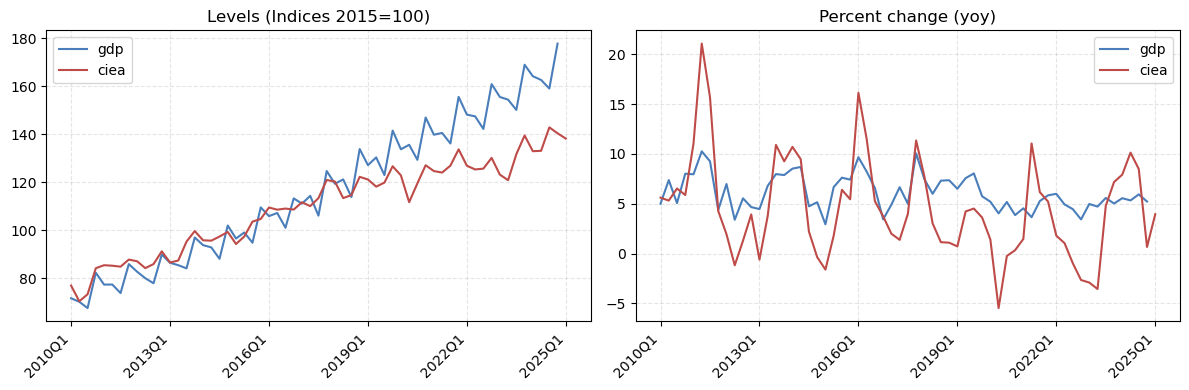

In [44]:
cieaplot(qciea)

## Correlation analysis by period

In [45]:
window_size = 20
n = qciea.dropna().shape[0]
chunks = n // window_size

print(f"Total observations: {n}")
# print(f"Full chunks of {window_size}: {chunks}")
# print(f"Remaining observations: {n % window_size}")

qciea1 = qciea.dropna().copy()
qciea1.reset_index(inplace=True, drop=True)
qciea1['yq'] = pd.PeriodIndex(qciea1['yq'], freq='Q')

print(f"First date: {qciea1.iloc[0]['yq']}")
print(f"Last date: {qciea1.iloc[-1]['yq']}")

corr_dict = {}

# Work backwards from the end to ensure last date is always included
for i in range(chunks):
    # Calculate indices working backwards from the end
    end_idx = n - 1 - (window_size * i)  # Start from last index and go backwards
    start_idx = end_idx - window_size + 1
    
    # Ensure we don't go below index 0
    if start_idx < 0:
        break
    
    # Calculate correlation for this window
    window_data = qciea1.loc[start_idx:end_idx, ['yoy_ciea', 'yoy_gdp_index']]
    cor = window_data.corr().iloc[0, 1]
    cor = np.round_(cor, 2)
    
    # Create period label
    period_start = qciea1.loc[start_idx, 'yq']
    period_end = qciea1.loc[end_idx, 'yq']
    period_label = f"{period_start}-{period_end}"
    
    corr_dict[period_label] = cor
    
    print(f"Window {i+1}: indices {start_idx}-{end_idx} -> {period_label} -> Correlation: {cor}")

# Since we worked backwards, reverse the dictionary to get chronological order
corr_dict_ordered = dict(reversed(list(corr_dict.items())))

# Create results dataframe
dfcorr = pd.DataFrame(corr_dict_ordered, index=[0]).T
dfcorr.columns = ['Correlation']
dfcorr.rename_axis('period', inplace=True)

# Save to excel
dfcorr.to_excel('correlation_slices.xlsx')

print(f"\nMean correlation: {dfcorr['Correlation'].mean():.3f}")
print(f"Number of windows: {len(dfcorr)}")
print(f"Last window ends at index: {n-1} (last available index)")

dfcorr

Total observations: 88
First date: 2003Q1
Last date: 2024Q4
Window 1: indices 68-87 -> 2020Q1-2024Q4 -> Correlation: 0.37
Window 2: indices 48-67 -> 2015Q1-2019Q4 -> Correlation: 0.71
Window 3: indices 28-47 -> 2010Q1-2014Q4 -> Correlation: 0.85
Window 4: indices 8-27 -> 2005Q1-2009Q4 -> Correlation: 0.44

Mean correlation: 0.593
Number of windows: 4
Last window ends at index: 87 (last available index)


Correlation
period                    
2005Q1-2009Q4         0.44
2010Q1-2014Q4         0.85
2015Q1-2019Q4         0.71
2020Q1-2024Q4         0.37

#### Plotting piecewise correlation

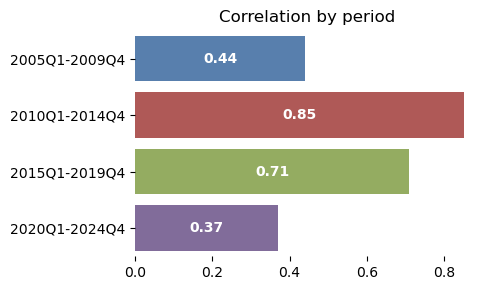

In [46]:
bot_colors = ["#4A7EBB", "#BE4B48", "#98B954", "#8064A2","#8C8278",
              "#46AAC5","#FABE64","#DCE6BE", "#C8FFFF", "#F79646","#2C4D75"]
plt.figure(figsize=(5, 3))
ax = sns.barplot(data=dfcorr, y=dfcorr.index, x='Correlation', orient='h', palette=bot_colors)

for i, container in enumerate(ax.containers):
    bars = container
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width/2, bar.get_y() + bar.get_height()/2., f'{width:.2f}',
                ha='center', va='center', color='white', fontweight='bold')

ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Correlation by period')
plt.tight_layout()
plt.savefig('corr_byperiod.png')
plt.show()

## Rolling correlation
- Rolling correlation is plotted to arcetain the trend of correlation overtime

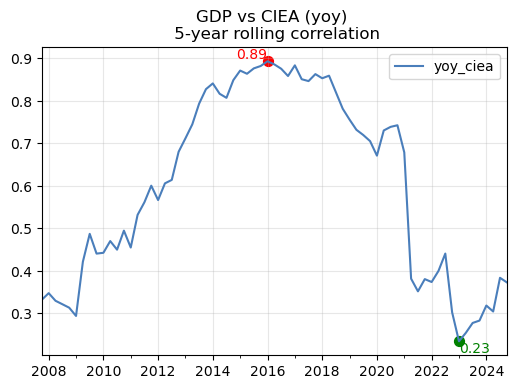

In [47]:
import matplotlib.cm as cm  # for colormap

# BOT COLORS
bot_colors = ["#4A7EBB", "#BE4B48", "#98B954", "#8064A2","#8C8278",
              "#46AAC5","#FABE64","#DCE6BE", "#C8FFFF", "#F79646","#2C4D75"]

qciea.index = qciea['yq']
roll_corr = qciea[['yoy_ciea']].rolling(20).corr(qciea['yoy_gdp_index'])
roll_corr = roll_corr.dropna()

# Set the index
qciea.index = pd.to_datetime(qciea['yq'])

# Calculate rolling correlation
roll_corr = qciea[['yoy_ciea']].rolling(20).corr(qciea['yoy_gdp_index'])
roll_corr.dropna(inplace=True)

# Find the date (index) and value of maximum correlation
max_corr_idx = pd.to_datetime(roll_corr['yoy_ciea'].idxmax())
max_corr_val = roll_corr['yoy_ciea'].max()


# Find the date (index) and value of minimum correlation
min_corr_idx = pd.to_datetime(roll_corr['yoy_ciea'].idxmin())
min_corr_val = roll_corr['yoy_ciea'].min()


# Plot with customizations
ax = roll_corr.plot(title='GDP vs CIEA (yoy) \n 5-year rolling correlation',
                    color=bot_colors[0], figsize = (6,4))


# Remove x-axis label
ax.set_xlabel('')
ax.grid(True, alpha=0.3)

# Add scatter plot for max correlation
ax.scatter(max_corr_idx, max_corr_val, color='red', s=50, label='Max Corr')
ax.text(max_corr_idx, max_corr_val, f'{max_corr_val:.2f}', verticalalignment='bottom', 
        horizontalalignment='right', color='red')

# Add scatter plot for min correlation
ax.scatter(min_corr_idx, min_corr_val, color='green', s=50, label='Min Corr')
ax.text(min_corr_idx, min_corr_val, f'{min_corr_val:.2f}', verticalalignment='top', 
        horizontalalignment='left', color='green')

# ax.get_legend().remove()

plt.show()

## Export weights  to excel
- The table shows weights optimised by two algorithms `Differential Evolution (DE)` and `Sequential Least Squares Programming (SLSP)`
- **DE** is slower, we may opt to switch it off
- In this case we use weights only derived from **SLSP**

In [48]:
if use_de_optimisation:
    df_weights = pd.concat([dfw_de, dfw_sc], axis=1)
    df_weights.columns = ['DE', 'SLSP']
else:
    df_weights = dfw_sc
    df_weights.columns = ['SLSP']


df_weights.rename_axis('Indicator', inplace=True)
df_weights.to_excel('optimal_weights.xlsx')

## Standard weights applied

In [59]:
optimizer = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)
qciea, weights = optimizer.calculate_ciea()

In [ ]:
# qciea['yoy_ciea'] = 0.6*qciea['yoy_ciea']


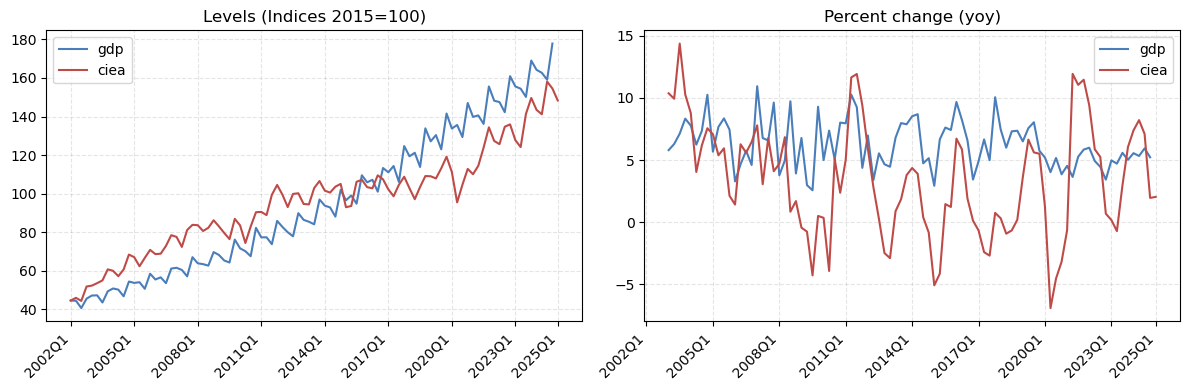

In [61]:
from codes.cieaplot import cieaplot
cieaplot(qciea, start_period="2002Q1")